# Comparing Total Gas Masses Between Analyses

This notebook measures gas masses for the samples we are using to verify our method, then compares them to the measurements from literature. While the focus of this work is the measurement of total galaxy cluster masses, comparing measured gas masses gives us an avenue to probe how similar our measurements of the baryon density of the clusters are to those from literature. Seeing as knowledge of the gas density profile feeds into the total gas mass, its important to know if we are consistent.

The XXL, LoCuSS, and Lovisari samples all have gas mass measurements associated with them which we will compare to, but the SDSSRM-XCS sample does not (such measurements will be presented in an upcoming paper).

## Import Statements

In [24]:
import pandas as pd
import numpy as np
from astropy.units import Quantity, Unit
from astropy.cosmology import LambdaCDM, WMAP9
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from copy import deepcopy

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 120
from xga.samples import ClusterSample
from xga.imagetools.psf import rl_psf
from xga.sourcetools.density import inv_abel_fitted_model, ann_spectra_apec_norm
from xga.models import BetaProfile1D, DoubleBetaProfile1D, KingProfile1D, SimpleVikhlininDensity1D
from xga.exceptions import ModelNotAssociatedError

## Defining useful functions

In [43]:
# This function is used for getting axis limits for the the one to one comparison plots later
def find_lims(x_dat, y_dat, buffer=0.1):
    # A buffer of some percent (default 10) is added to the max and min values to make the plot 
    #  more easily readable
    lom = 1 - buffer
    him = 1 + buffer
    
    # Check if either are all NaNs
    if np.isnan(x_dat).all():
        x_dat = y_dat.copy()
    if np.isnan(y_dat).all():
        y_dat = x_dat.copy()
    
    # Reading out the values without errors
    x_vals = x_dat[:, 0]
    y_vals = y_dat[:, 0]
    
    # Depending on whether the input data has + and - errors, or just a standard deviation, depends how
    #  we find maximum and minimum values
    if x_dat.shape[1] == 3:
        # In this case upper and lower errors are present
        lb = x_vals-x_dat[:, 1]
        # Make sure that we don't count any NaN values, and don't count any negative values
        #  The lower errors are subtracted from the measurements, and upper values added to them
        #  Then max and mins are found 
        x_lims = [np.nanmin(lb[np.where(lb>0)[0]]), np.nanmax(x_vals+x_dat[:, 2])]
    elif x_dat.shape[1] == 2:
        # The behaviour is largely the same as above, but for symmetrical errors
        lb = x_vals-x_dat[:, 1]
        x_lims = [np.nanmin(lb[np.where(lb>0)[0]]), np.nanmax(x_vals+x_dat[:, 1])]
    
    if y_dat.shape[1] == 3:
        lb = y_vals-y_dat[:, 1]
        y_lims = [np.nanmin(lb[np.where(lb>0)[0]]), np.nanmax(y_vals+y_dat[:, 2])]
    elif y_dat.shape[1] == 2:
        lb = y_vals-y_dat[:, 1]
        y_lims = [np.nanmin(lb[np.where(lb>0)[0]]), np.nanmax(y_vals+y_dat[:, 1])]
    
    # Then find the minimum and maximum values from the min and max x and y data, and multiply by the buffer
    lims = Quantity([lom*min([x_lims[0], y_lims[0]]), him*max([x_lims[1], y_lims[1]])])
    
    # Return the limits for the square like for like comparison plot
    return lims

## Reading colour configuration file

In [3]:
samp_colours = pd.read_csv("samp_plot_colours.csv")

lov_colour = samp_colours[samp_colours['samp_name'] == 'lovisari'].iloc[0]['samp_colour']
xxl_colour = samp_colours[samp_colours['samp_name'] == 'xxl'].iloc[0]['samp_colour']
loc_colour = samp_colours[samp_colours['samp_name'] == 'locuss'].iloc[0]['samp_colour']

## Setting up cosmology

The LoCuSS and Lovisari analyses use the same concordance cosmology, but the XXL analysis of their bright cluster sample uses the WMAP9 results, and in case we wish to change anything for an individual sample later we define three separate cosmology objects to pass into our samples.

In [4]:
xxl_cosmo = WMAP9
locuss_cosmo = LambdaCDM(70, 0.3, 0.7)
lovisari_cosmo = LambdaCDM(70, 0.3, 0.7)

## Reading in Sample Files and Declaring XGA ClusterSamples

$\color{red}{\text{NEED TO MENTION/PUBLISH THE OBSIDS THAT WE EXCLUDE FROM USE DUE TO DATA PROBLEMS LIKE FLARING}}$

This subsection involves reading in the sample files of the four test samples (described in [the sample properties notebook](sample_properties.ipynb)), then setting up separate XGA ClusterSample instances (see [the documentation](https://xga.readthedocs.io/en/latest/notebooks/tutorials/sources_samples.html) for an introduction to XGA source and sample objects.

We impose an additional cleaning step on each sample, where we make sure that (for each XMM observation initially associated with a source) at least 70% of a cluster's $R_{500}$ falls on that observation - if this requirement is not met then the observation is excluded. These requirements are set with the `clean_obs=True`, `clean_obs_reg='r500'`, and `clean_obs_threshold=0.7` arguments when a ClusterSample instance is declared.

### XXL-100-GC

This is the sample of the brightest clusters in the XXL survey. It contains temperature and luminosity measurements, and will be a useful external comparison for XGA results, though the shallow XXL data may prove a challenge.

In [5]:
xxlgc100 = pd.read_csv("sample_files/xxl_gc100.csv")

# Limit the comparison to clusters with a flag of 0 - meaning it is in the main sample of 100 clusters
xxlgc100 = xxlgc100[xxlgc100['Flag'] == 0]

# Excluding a specific cluster which was excluded in the XXL analysis
xxlgc100 = xxlgc100[xxlgc100['XLSSC'] != 504]

In [6]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = xxlgc100['ra'].values
dec = xxlgc100['dec'].values
z = xxlgc100['z'].values
n = xxlgc100['name'].values
r500 = Quantity(xxlgc100['r500MT'].values, 'Mpc')

# Declaring the actual ClusterSample instance for the XXL sample
# This is the only sample whose original analysis used the WMAP9 cosmology
xxl_srcs = ClusterSample(ra, dec, z, n, r500=r500, cosmology=xxl_cosmo, load_fits=True, use_peak=False, 
                         clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Setting up Galaxy Clusters:   0%|                                                      | 0/99 [00:00<?, ?it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-94 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:   1%|▍                                             | 1/99 [00:06<09:54,  6.07s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-96 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:   2%|▉                                             | 2/99 [00:15<12:33,  7.76s/it]/mnt/pact/dt23

Setting up Galaxy Clusters:  17%|███████▋                                     | 17/99 [01:40<07:10,  5.25s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-98 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  18%|████████▏                                    | 18/99 [01:44<06:52,  5.10s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-99 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  19%|████████▋                                    | 19/99 [01:50<06:47,  5.09s/it]/mnt/pact/dt23

Setting up Galaxy Clusters:  32%|██████████████▌                              | 32/99 [04:21<14:33, 13.04s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:109: UserWarning: There are 1 alternative matches for observation 0404965201, associated with source XLSSC-54
  warnings.warn("There are {0} alternative matches for observation {1}, associated with "
Setting up Galaxy Clusters:  33%|███████████████                              | 33/99 [04:27<11:59, 10.91s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:109: UserWarning: There are 1 alternative matches for observation 0780452501, associated with source XLSSC-25
  warnings.warn("There are {0} alternative matches for observation {1}, associated with "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:109: UserWarning: There are 1 alternative matches for observation 0109520401, associated with source XLSSC-25
  warnings.warn("There are {0} alternative matches for observation {1}, associ

Setting up Galaxy Clusters:  45%|████████████████████▍                        | 45/99 [07:40<12:44, 14.16s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-89 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  46%|████████████████████▉                        | 46/99 [07:49<11:04, 12.53s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/extended.py:222: UserWarning: A point source has been detected in 0677600133 and is very close to the user supplied coordinates of XLSSC-104. It will not be excluded from analysis due to the possibility of a mis-identified cool core
  warnings.warn("A point source has been detected in {o} and is very close to the user supplied "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124:

Setting up Galaxy Clusters:  62%|███████████████████████████▋                 | 61/99 [09:02<02:17,  3.62s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-518 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  63%|████████████████████████████▏                | 62/99 [09:05<02:03,  3.35s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:109: UserWarning: There are 1 alternative matches for observation 0604873944, associated with source XLSSC-531
  warnings.warn("There are {0} alternative matches for observation {1}, associated with "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-531 has not been detected in all region files, so generating and fitting products with the 'region

Setting up Galaxy Clusters:  77%|██████████████████████████████████▌          | 76/99 [10:05<01:32,  4.03s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-505 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  78%|███████████████████████████████████          | 77/99 [10:08<01:20,  3.67s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:109: UserWarning: There are 1 alternative matches for observation 0677720134, associated with source XLSSC-506
  warnings.warn("There are {0} alternative matches for observation {1}, associated with "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-506 has not been detected in all region files, so generating and fitting products with the 'region

Setting up Galaxy Clusters:  93%|█████████████████████████████████████████▊   | 92/99 [11:12<00:35,  5.14s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-541 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  94%|██████████████████████████████████████████▎  | 93/99 [11:16<00:29,  4.98s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-508 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  95%|██████████████████████████████████████████▋  | 94/99 [11:27<00:33,  6.61s/it]/mnt/pact/dt

### LoCuSS High-$L_{\rm{X}}$

The LoCuSS High-$L_{\rm{X}}$ sample was selected from ROSAT for its high luminosity clusters, and will again be a useful comparison as testing against various different analyses is beneficial in establishing the veracity of our new measurements.

In [7]:
locuss = pd.read_csv("sample_files/locuss_highlx_clusters.csv", dtype={'chandra_id': str, 'xmm_obsid': str})

In [8]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = locuss['ra'].values
dec = locuss['dec'].values
z = locuss['z'].values
n = locuss['name'].values
r500 = Quantity(locuss['r500'].values, 'kpc')
r2500 = Quantity(locuss['r2500'].values, 'kpc')


# Declaring the actual ClusterSample instance for the LoCuSS sample
locuss_srcs = ClusterSample(ra, dec, z, n, r500=r500, r2500=r2500, cosmology=locuss_cosmo, load_fits=True, 
                            use_peak=False, clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Declaring BaseSource Sample:  36%|███████████████▊                            | 18/50 [01:01<01:59,  3.75s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:91: UserWarning: Source ZwCl0949.6+5207 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  46%|████████████████████▏                       | 23/50 [01:19<01:48,  4.01s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:91: UserWarning: Source Abell1423 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  54%|███████████████████████▊                    | 27/50 [01:27<01:06,  2.89s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:91: UserWarning: Source Abell1682 does not appear to have any XMM data, and

### Planck Selected with XMM follow-up

The Lovisari et al. sample was selected from Planck-eSZ, and will again be a useful comparison as testing against various different analyses is beneficial in establishing the veracity of our new measurements.

In [9]:
lovisari = pd.read_csv("sample_files/lovisari_planck_clusters.csv")

In [10]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = lovisari['planck_ra'].values
dec = lovisari['planck_dec'].values
z = lovisari['z'].values
n = lovisari['name'].values
r500 = Quantity(lovisari['r500'].values, 'kpc')

# Declaring the actual ClusterSample instance for the Lovisari sample
lovisari_srcs = ClusterSample(ra, dec, z, n, r500=r500, cosmology=lovisari_cosmo, load_fits=True, use_peak=False, 
                            clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Declaring BaseSource Sample:  50%|█████████████████████▌                     | 60/120 [04:44<03:34,  3.58s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.17-21.91 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0675470101/0675470101_mos2_G226.17-21.91_ra88.262_dec-21.062_ri0.0483332993719956_ro0.05437496179349506_grpTrue_mincnt5_ident72837747_6_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
Setting up Galaxy Clusters:   3%|█▌                                           | 4/120 [00:16<08:32,  4.42s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:963: UserWarning: A previous annular spectra profile fit for G006.78+30.46 was not successful, or no matching spectrum has been loaded, so it cannot be read in
  warnings.warn("A previous annular spectra profile fit for {src}

Setting up Galaxy Clusters:  32%|█████████████▉                              | 38/120 [03:09<06:23,  4.67s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:963: UserWarning: A previous annular spectra profile fit for G098.95+24.86 was not successful, or no matching spectrum has been loaded, so it cannot be read in
  warnings.warn("A previous annular spectra profile fit for {src} was not successful, or no "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/extended.py:222: UserWarning: A point source has been detected in 0692930701 and is very close to the user supplied coordinates of G098.95+24.86. It will not be excluded from analysis due to the possibility of a mis-identified cool core
  warnings.warn("A point source has been detected in {o} and is very close to the user supplied "
Setting up Galaxy Clusters:  32%|██████████████▎                             | 39/120 [03:11<05:16,  3.91s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarn

Setting up Galaxy Clusters:  66%|████████████████████████████▉               | 79/120 [05:44<02:32,  3.71s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/extended.py:222: UserWarning: A point source has been detected in 0042340301 and is very close to the user supplied coordinates of G260.03-63.44. It will not be excluded from analysis due to the possibility of a mis-identified cool core
  warnings.warn("A point source has been detected in {o} and is very close to the user supplied "
Setting up Galaxy Clusters:  69%|██████████████████████████████▍             | 83/120 [05:57<01:54,  3.08s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: G263.66-22.53 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  70%|██████████████████████████

## Running PSF Correction

In [11]:
rl_psf(xxl_srcs)
rl_psf(locuss_srcs)
rl_psf(lovisari_srcs)

## Reading in literature data

### Gas masses from literature

In [12]:
xxl_lit_gms = [xxlgc100[xxlgc100['name'] == n].iloc[0][['mg500', 'mg500_err']].values*1e+13 
               for n in xxl_srcs.names]
xxl_lit_gms = Quantity(xxl_lit_gms, 'Msun')

lov_lit_gms = [lovisari[lovisari['name'] == n].iloc[0][['mg500', 'mg500-', 'mg500+']].values*1e+13
               for n in lovisari_srcs.names]
lov_lit_gms = Quantity(lov_lit_gms, 'Msun')

loc_lit_gms = [locuss[locuss['name'] == n].iloc[0][['x_mg500', 'x_mg500_err']].values
               for n in locuss_srcs.names]
loc_lit_gms = Quantity(loc_lit_gms, 'Msun')

### Conversion Temperatures

In [13]:
xxl_conv_txs = []
loc_conv_txs = []
lov_conv_txs = []

for src in xxl_srcs:
    xxl_conv_txs.append(xxlgc100[xxlgc100['name'] == src.name].iloc[0]['T300kpc'])
    
for src in locuss_srcs:
    loc_conv_txs.append(locuss[locuss['name'] == src.name].iloc[0]['x_Tx500ce'])

for src in lovisari_srcs:
    lov_conv_txs.append(lovisari[lovisari['name'] == src.name].iloc[0]['Tx'])

xxl_conv_txs = Quantity(xxl_conv_txs, 'keV')
loc_conv_txs = Quantity(loc_conv_txs, 'keV')
lov_conv_txs = Quantity(lov_conv_txs, 'keV')

## Gas Density Profile Generation and Comparison to Literature - from $S_{B}$ Profiles

### Beta and King Profiles - out to 1.3$R_{500}$

In [ ]:
sb_mod = BetaProfile1D()
sb_mod.info()
sb_mod.par_priors

In [ ]:
xxl_beta_13_dp = inv_abel_fitted_model(xxl_srcs, sb_mod, 'mcmc', xxl_srcs.r500*1.3, 
                                       conv_temp=xxl_conv_txs, conv_outer_radius=Quantity(300, 'kpc'))
lov_beta_13_dp = inv_abel_fitted_model(lovisari_srcs, sb_mod, 'mcmc', lovisari_srcs.r500*1.3, 
                                       conv_temp=lov_conv_txs)
loc_beta_13_dp = inv_abel_fitted_model(locuss_srcs, sb_mod, 'mcmc', locuss_srcs.r500*1.3, 
                                       conv_temp=loc_conv_txs)

In [ ]:
d_mod = KingProfile1D(y_unit=Unit("1 / cm^3"))
d_mod.info()
d_mod.par_priors

In [ ]:
with tqdm(desc="Fitting density model to XXL profiles", total=len(xxl_beta_13_dp)) as onwards:
    for dp in xxl_beta_13_dp:
        if dp is not None:
            dp.fit(d_mod, progress_bar=False)
        onwards.update(1)

with tqdm(desc="Fitting density model to Lovisari profiles", total=len(lov_beta_13_dp)) as onwards:
    for dp in lov_beta_13_dp:
        if dp is not None:
            dp.fit(d_mod, progress_bar=False)
        onwards.update(1)

with tqdm(desc="Fitting density model to LoCuSS profiles", total=len(loc_beta_13_dp)) as onwards:
    for dp in loc_beta_13_dp:
        if dp is not None:
            dp.fit(d_mod, progress_bar=False)
        onwards.update(1)


In [ ]:
xxl_beta_king_13_gm = []
with tqdm(desc="Calculating XXL gas masses", total=len(xxl_beta_13_dp)) as onwards:
    for dp in xxl_beta_13_dp:
        if dp is not None:
            gm = dp.gas_mass("king", xxl_srcs[dp.src_name].r500)[0]
            xxl_beta_king_13_gm.append(gm)
        else:
            xxl_beta_king_13_gm.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)

lov_beta_king_13_gm = []
with tqdm(desc="Calculating Lovisari gas masses", total=len(lov_beta_13_dp)) as onwards:
    for dp in lov_beta_13_dp:
        if dp is not None:
            gm = dp.gas_mass("king", lovisari_srcs[dp.src_name].r500)[0]
            lov_beta_king_13_gm.append(gm)
        else:
            lov_beta_king_13_gm.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)        
        
loc_beta_king_13_gm = []
with tqdm(desc="Calculating LoCuSS gas masses", total=len(loc_beta_13_dp)) as onwards:
    for dp in loc_beta_13_dp:
        if dp is not None:
            gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r500)[0]
            loc_beta_king_13_gm.append(gm)
        else:
            loc_beta_king_13_gm.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)        
        
xxl_beta_king_13_gm = Quantity(xxl_beta_king_13_gm, 'Msun')
lov_beta_king_13_gm = Quantity(lov_beta_king_13_gm, 'Msun')
loc_beta_king_13_gm = Quantity(loc_beta_king_13_gm, 'Msun')

In [ ]:
# Setting the y-position and font size of the a, b, and c labels that are added below the subplots
sublabel_ypos = -0.115
sublabel_fsize = 14

# Set up the matplotlib figure with 3 columns, meaning three subplots
fig, ax_arr = plt.subplots(ncols=3, figsize=(16, 6))

# Iterating through the array of axes objects, setting up the ticks
for ax in ax_arr:
    ax.minorticks_on()
    ax.tick_params(which='both', top=True, right=True, direction='in')

# Reading out the first axis in the array of axes
ax = ax_arr[0]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
xxl_lims = find_lims(xxl_lit_gms, xxl_beta_king_13_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(xxl_lims, xxl_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(xxl_lit_gms[:, 0].value, xxl_beta_king_13_gm[:, 0].value, xerr=xxl_lit_gms[:, 1].value, 
             yerr=[xxl_beta_king_13_gm[:, 1].value, xxl_beta_king_13_gm[:, 2].value], fmt='x', 
             color=xxl_colour, capsize=2, label="XXL-100-GC")

# # Labelling axes, setting labels etc.
ax.set_xlabel(r"XXL Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(xxl_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(xxl_lims)

# Add the a) label below this first plot
ax.text(0.5, sublabel_ypos, s='a)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Reading out the second axis in the array of axes
ax = ax_arr[1]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
lov_lims = find_lims(lov_lit_gms, lov_beta_king_13_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(lov_lims, lov_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(lov_lit_gms[:, 0].value, lov_beta_king_13_gm[:, 0].value, 
             xerr=[lov_lit_gms[:, 1].value, lov_lit_gms[:, 2].value], 
             yerr=[lov_beta_king_13_gm[:, 1].value, lov_beta_king_13_gm[:, 2].value], fmt='x', 
             color=lov_colour, capsize=2, label="Lovisari et al.")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"Lovisari Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(lov_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(lov_lims)
ax.text(0.5, sublabel_ypos, s='b)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Reading out the last axis in the array of axes
ax = ax_arr[2]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
loc_lims = find_lims(loc_lit_gms, loc_beta_king_13_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(loc_lims, loc_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(loc_lit_gms[:, 0].value, loc_beta_king_13_gm[:, 0].value, 
             xerr=loc_lit_gms[:, 1].value, 
             yerr=[loc_beta_king_13_gm[:, 1].value, loc_beta_king_13_gm[:, 2].value], fmt='x', 
             color=loc_colour, capsize=2, label=r"LoCuSS High-$L_{\rm{X}}$")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"LoCuSS Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(loc_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(loc_lims)
ax.text(0.5, sublabel_ypos, s='c)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Saving and plotting the resulting figure
plt.tight_layout()
# plt.savefig("non_paper_figures/xxl_lov_loc_beta_king_1.3r500_gm_comp.pdf")
plt.show()

### Double Beta and Simplified Vikhlinin Profiles - out to 1.3$R_{500}$

In [ ]:
sb_mod = DoubleBetaProfile1D()
sb_mod.info()

xxl_dblbeta_13_dp = inv_abel_fitted_model(xxl_srcs, sb_mod, 'mcmc', xxl_srcs.r500*1.3, 
                                       conv_temp=xxl_conv_txs, conv_outer_radius=Quantity(300, 'kpc'))
lov_dblbeta_13_dp = inv_abel_fitted_model(lovisari_srcs, sb_mod, 'mcmc', lovisari_srcs.r500*1.3, 
                                       conv_temp=lov_conv_txs)
loc_dblbeta_13_dp = inv_abel_fitted_model(locuss_srcs, sb_mod, 'mcmc', locuss_srcs.r500*1.3, 
                                       conv_temp=loc_conv_txs)

In [ ]:
d_mod = SimpleVikhlininDensity1D(y_unit=Unit("1 / cm^3"))
d_mod.info()
print(d_mod.par_priors)

with tqdm(desc="Fitting density model to XXL profiles", total=len(xxl_dblbeta_13_dp)) as onwards:
    for dp in xxl_dblbeta_13_dp:
        if dp is not None:
            dp.fit(d_mod, progress_bar=False)
        onwards.update(1)

with tqdm(desc="Fitting density model to Lovisari profiles", total=len(lov_dblbeta_13_dp)) as onwards:
    for dp in lov_dblbeta_13_dp:
        if dp is not None:
            dp.fit(d_mod, progress_bar=False)
        onwards.update(1)

with tqdm(desc="Fitting density model to LoCuSS profiles", total=len(loc_dblbeta_13_dp)) as onwards:
    for dp in loc_dblbeta_13_dp:
        if dp is not None:
            dp.fit(d_mod, progress_bar=False)
        onwards.update(1)


In [ ]:
xxl_dblbeta_svikh_13_gm = []
with tqdm(desc="Calculating XXL gas masses", total=len(xxl_dblbeta_13_dp)) as onwards:
    for dp in xxl_dblbeta_13_dp:
        if dp is not None:
            gm = dp.gas_mass("simple_vikhlinin_dens", xxl_srcs[dp.src_name].r500)[0]
            xxl_dblbeta_svikh_13_gm.append(gm)
        else:
            xxl_dblbeta_svikh_13_gm.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)

lov_dblbeta_svikh_13_gm = []
with tqdm(desc="Calculating Lovisari gas masses", total=len(lov_dblbeta_13_dp)) as onwards:
    for dp in lov_dblbeta_13_dp:
        if dp is not None:
            gm = dp.gas_mass("simple_vikhlinin_dens", lovisari_srcs[dp.src_name].r500)[0]
            lov_dblbeta_svikh_13_gm.append(gm)
        else:
            lov_dblbeta_svikh_13_gm.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)        
        
loc_dblbeta_svikh_13_gm = []
with tqdm(desc="Calculating LoCuSS gas masses", total=len(loc_dblbeta_13_dp)) as onwards:
    for dp in loc_dblbeta_13_dp:
        if dp is not None:
            gm = dp.gas_mass("simple_vikhlinin_dens", locuss_srcs[dp.src_name].r500)[0]
            loc_dblbeta_svikh_13_gm.append(gm)
        else:
            loc_dblbeta_svikh_13_gm.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)        
        
xxl_dblbeta_svikh_13_gm = Quantity(xxl_dblbeta_svikh_13_gm, 'Msun')
lov_dblbeta_svikh_13_gm = Quantity(lov_dblbeta_svikh_13_gm, 'Msun')
loc_dblbeta_svikh_13_gm = Quantity(loc_dblbeta_svikh_13_gm, 'Msun')

In [ ]:
# Setting the y-position and font size of the a, b, and c labels that are added below the subplots
sublabel_ypos = -0.115
sublabel_fsize = 14

# Set up the matplotlib figure with 3 columns, meaning three subplots
fig, ax_arr = plt.subplots(ncols=3, figsize=(16, 6))

# Iterating through the array of axes objects, setting up the ticks
for ax in ax_arr:
    ax.minorticks_on()
    ax.tick_params(which='both', top=True, right=True, direction='in')

# Reading out the first axis in the array of axes
ax = ax_arr[0]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
xxl_lims = find_lims(xxl_lit_gms, xxl_dblbeta_svikh_13_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(xxl_lims, xxl_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(xxl_lit_gms[:, 0].value, xxl_dblbeta_svikh_13_gm[:, 0].value, xerr=xxl_lit_gms[:, 1].value, 
             yerr=[xxl_dblbeta_svikh_13_gm[:, 1].value, xxl_dblbeta_svikh_13_gm[:, 2].value], fmt='x', 
             color=xxl_colour, capsize=2, label="XXL-100-GC")

# # Labelling axes, setting labels etc.
ax.set_xlabel(r"XXL Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(xxl_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(xxl_lims)

# Add the a) label below this first plot
ax.text(0.5, sublabel_ypos, s='a)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Reading out the second axis in the array of axes
ax = ax_arr[1]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
lov_lims = find_lims(lov_lit_gms, lov_dblbeta_svikh_13_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(lov_lims, lov_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(lov_lit_gms[:, 0].value, lov_dblbeta_svikh_13_gm[:, 0].value, 
             xerr=[lov_lit_gms[:, 1].value, lov_lit_gms[:, 2].value], 
             yerr=[lov_dblbeta_svikh_13_gm[:, 1].value, lov_dblbeta_svikh_13_gm[:, 2].value], fmt='x', 
             color=lov_colour, capsize=2, label="Lovisari et al.")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"Lovisari Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(lov_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(lov_lims)
ax.text(0.5, sublabel_ypos, s='b)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Reading out the last axis in the array of axes
ax = ax_arr[2]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
loc_lims = find_lims(loc_lit_gms, loc_dblbeta_svikh_13_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(loc_lims, loc_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(loc_lit_gms[:, 0].value, loc_dblbeta_svikh_13_gm[:, 0].value, 
             xerr=loc_lit_gms[:, 1].value, 
             yerr=[loc_dblbeta_svikh_13_gm[:, 1].value, loc_dblbeta_svikh_13_gm[:, 2].value], fmt='x', 
             color=loc_colour, capsize=2, label=r"LoCuSS High-$L_{\rm{X}}$")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"LoCuSS Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(loc_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(loc_lims)
ax.text(0.5, sublabel_ypos, s='c)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Saving and plotting the resulting figure
plt.tight_layout()
plt.savefig("non_paper_figures/xxl_lov_loc_dblbeta_svikh_1.3r500_gm_comp.pdf")
plt.show()

## Gas Density Profile Generation and Comparison to Literature - from Annular Spectra

### Simplified Vikhlinin Profiles - out to $R_{500}$

In [ ]:
loc_annspec_10_dp = ann_spectra_apec_norm(locuss_srcs, locuss_srcs.r500, min_snr=30)
lov_annspec_10_dp = ann_spectra_apec_norm(lovisari_srcs, lovisari_srcs.r500, min_snr=30)

In [ ]:
dpath = "non_paper_figures/density_profiles/svikh_1r500_annspec/"
if not os.path.exists(dpath):
    os.makedirs(dpath+"lovisari")
    os.makedirs(dpath+"locuss") 

lov_svikh_10_annspec_gm = []
with tqdm(desc="Measuring Lovisari Gas Masses", total=len(lov_annspec_10_dp)) as onwards:
    for dp in lov_annspec_10_dp:
        if dp is not None:
            rel_src = lovisari_srcs[dp.src_name]
            # Fit a simplified Vikhlinin density profile
            dp.fit("simple_vikhlinin_dens", progress_bar=False)
            dp.savefig(dpath+"lovisari/{}.pdf".format(rel_src.name))
            try:
                # Measure a gas mass within R500
                gm = dp.gas_mass("simple_vikhlinin_dens", rel_src.r500)[0]
                lov_svikh_10_annspec_gm.append(gm)
            except ModelNotAssociatedError:
                lov_svikh_10_annspec_gm.append([np.NaN, np.NaN, np.NaN])
        else:
            lov_svikh_10_annspec_gm.append([np.NaN, np.NaN, np.NaN])
    
        onwards.update(1)

loc_svikh_10_annspec_gm = []
with tqdm(desc="Measuring LoCuSS Gas Masses", total=len(loc_annspec_10_dp)) as onwards:
    for dp in loc_annspec_10_dp:
        if dp is not None:
            rel_src = locuss_srcs[dp.src_name]
            # Fit a simplified Vikhlinin density profile
            dp.fit("simple_vikhlinin_dens", progress_bar=False)
            dp.savefig(dpath+"locuss/{}.pdf".format(rel_src.name))
            try:
                # Measure a gas mass within R500
                gm = dp.gas_mass("simple_vikhlinin_dens", rel_src.r500)[0]
                loc_svikh_10_annspec_gm.append(gm)
            except ModelNotAssociatedError:
                loc_svikh_10_annspec_gm.append([np.NaN, np.NaN, np.NaN])
        else:
            loc_svikh_10_annspec_gm.append([np.NaN, np.NaN, np.NaN])
    
        onwards.update(1)

lov_svikh_10_annspec_gm = Quantity(lov_svikh_10_annspec_gm, 'Msun').astype(float)
loc_svikh_10_annspec_gm = Quantity(loc_svikh_10_annspec_gm, 'Msun').astype(float)

In [ ]:
# Setting the y-position and font size of the a and b  labels that are added below the subplots
sublabel_ypos = -0.115
sublabel_fsize = 14

# Set up the matplotlib figure with 2 columns, meaning three subplots
fig, ax_arr = plt.subplots(ncols=2, figsize=(12, 6))

# Iterating through the array of axes objects, setting up the ticks
for ax in ax_arr:
    ax.minorticks_on()
    ax.tick_params(which='both', top=True, right=True, direction='in')

# Reading out the first axis in the array of axes
ax = ax_arr[0]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
lov_lims = find_lims(lov_lit_gms, lov_svikh_10_annspec_gm).value
lov_lims[1] = 5e+14

# Plotting a 1:1 line to help with comparisons
plt.plot(lov_lims, lov_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(lov_lit_gms[:, 0].value, lov_svikh_10_annspec_gm[:, 0].value, 
             xerr=lov_lit_gms[:, 1:].T.value, 
             yerr=lov_svikh_10_annspec_gm[:, 1:].T.value, fmt='x', 
             color=lov_colour, capsize=2, label="Lovisari et al.")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"Lovisari Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(lov_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(lov_lims)
ax.text(0.5, sublabel_ypos, s='a)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Reading out the second axis in the array of axes
ax = ax_arr[1]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
loc_lims = find_lims(loc_lit_gms, loc_svikh_10_annspec_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(loc_lims, loc_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(loc_lit_gms[:, 0].value, loc_svikh_10_annspec_gm[:, 0].value, 
             xerr=loc_lit_gms[:, 1].value, 
             yerr=loc_svikh_10_annspec_gm[:, 1:].T.value, fmt='x', 
             color=loc_colour, capsize=2, label=r"LoCuSS High-$L_{\rm{X}}$")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"LoCuSS Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(loc_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(loc_lims)
ax.text(0.5, sublabel_ypos, s='b)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

plt.tight_layout()

# Saving and plotting the resulting figure
plt.savefig("non_paper_figures/lov_loc_svikh_1r500_annspec_gm_comp.pdf")
plt.show()

### Simplified Vikhlinin Profiles - out to 1.3$R_{500}$

In [14]:
loc_annspec_13_dp = ann_spectra_apec_norm(locuss_srcs, locuss_srcs.r500*1.3, min_snr=30)
lov_annspec_13_dp = ann_spectra_apec_norm(lovisari_srcs, lovisari_srcs.r500*1.3, min_snr=30)

Generating products of type(s) spectrum: 100%|████████████████████████████| 210/210 [1:40:30<00:00, 28.72s/it]
Generating products of type(s) annular spectrum set components: 100%|███| 2712/2712 [2:34:15<00:00,  3.41s/it]
Running XSPEC Fits: 100%|███████████████████████████████████████████████████| 588/588 [24:30<00:00,  2.50s/it]
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:326: UserWarning: Abell0068 annular spectra profile fit was not successful
  warnings.warn("{src} annular spectra profile fit was not successful".format(src=ann_spec.src_name))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:326: UserWarning: Abell141 annular spectra profile fit was not successful
  warnings.warn("{src} annular spectra profile fit was not successful".format(src=ann_spec.src_name))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:326: UserWarning: Abell0697 annular spectra profile fit was not successful
  warnings.warn("{src} annular spectra profile fit was not succes

SASGenerationError: [[SASGenerationError('/bin/sh: line 1: 101436 Segmentation fault      (core dumped) arfgen spectrumset=0551280201_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits arfset=0551280201_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5.arf withrmfset=yes rmfset=0551280201_mos1_G226.24x76.76_universal.rmf badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0551280201/xga/best_mos1_clean_evts.fits extendedsource=yes detmaptype=dataset detmaparray=0551280201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0551280201-mos1.'), SASGenerationError('/bin/sh: line 1: 101456 Segmentation fault      (core dumped) backscale spectrumset=0551280201_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0551280201/xga/best_mos1_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0551280201-mos1.'), SASGenerationError('/bin/sh: line 1: 101457 Segmentation fault      (core dumped) backscale spectrumset=0551280201_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_backspec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0551280201/xga/best_mos1_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0551280201-mos1.'), SASGenerationError('/bin/sh: line 1: 101458 Segmentation fault      (core dumped) specgroup spectrumset=0551280201_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0551280201_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_backspec.fits arfset=0551280201_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5.arf rmfset=0551280201_mos1_G226.24x76.76_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0551280201-mos1.'), SASGenerationError('/bin/sh: line 1: 101473 Segmentation fault      (core dumped) arfgen spectrumset=0551280201_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits arfset=0551280201_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5.arf withrmfset=yes rmfset=0551280201_mos2_G226.24x76.76_universal.rmf badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0551280201/xga/best_mos2_clean_evts.fits extendedsource=yes detmaptype=dataset detmaparray=0551280201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0551280201-mos2.'), SASGenerationError('/bin/sh: line 1: 101500 Segmentation fault      (core dumped) backscale spectrumset=0551280201_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0551280201/xga/best_mos2_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0551280201-mos2.'), SASGenerationError('/bin/sh: line 1: 101501 Segmentation fault      (core dumped) backscale spectrumset=0551280201_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_backspec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0551280201/xga/best_mos2_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0551280201-mos2.'), SASGenerationError('/bin/sh: line 1: 101502 Segmentation fault      (core dumped) specgroup spectrumset=0551280201_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0551280201_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_backspec.fits arfset=0551280201_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5.arf rmfset=0551280201_mos2_G226.24x76.76_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0551280201-mos2.'), SASGenerationError('/bin/sh: line 1: 101477 Segmentation fault      (core dumped) arfgen spectrumset=0551280201_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits arfset=0551280201_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5.arf withrmfset=yes rmfset=0551280201_pn_G226.24x76.76_universal.rmf badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0551280201/xga/best_pn_clean_evts.fits extendedsource=yes detmaptype=dataset detmaparray=0551280201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0551280201-pn.'), SASGenerationError('/bin/sh: line 1: 101517 Segmentation fault      (core dumped) backscale spectrumset=0551280201_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0551280201/xga/best_pn_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0551280201-pn.'), SASGenerationError('/bin/sh: line 1: 101518 Segmentation fault      (core dumped) backscale spectrumset=0551280201_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_backspec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0551280201/xga/best_pn_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0551280201-pn.'), SASGenerationError('/bin/sh: line 1: 101564 Segmentation fault      (core dumped) specgroup spectrumset=0551280201_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0551280201_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_backspec.fits arfset=0551280201_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5.arf rmfset=0551280201_pn_G226.24x76.76_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0551280201-pn.'), SASGenerationError('/bin/sh: line 1: 101497 Segmentation fault      (core dumped) arfgen spectrumset=0502690201_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits arfset=0502690201_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5.arf withrmfset=yes rmfset=0502690201_mos1_G226.24x76.76_universal.rmf badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0502690201/xga/best_mos1_clean_evts.fits extendedsource=yes detmaptype=dataset detmaparray=0502690201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0502690201-mos1.'), SASGenerationError('/bin/sh: line 1: 101658 Segmentation fault      (core dumped) backscale spectrumset=0502690201_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0502690201/xga/best_mos1_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0502690201-mos1.'), SASGenerationError('/bin/sh: line 1: 101659 Segmentation fault      (core dumped) backscale spectrumset=0502690201_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_backspec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0502690201/xga/best_mos1_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0502690201-mos1.'), SASGenerationError('/bin/sh: line 1: 101660 Segmentation fault      (core dumped) specgroup spectrumset=0502690201_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0502690201_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_backspec.fits arfset=0502690201_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5.arf rmfset=0502690201_mos1_G226.24x76.76_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0502690201-mos1.'), SASGenerationError('/bin/sh: line 1: 101668 Segmentation fault      (core dumped) arfgen spectrumset=0502690201_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits arfset=0502690201_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5.arf withrmfset=yes rmfset=0502690201_mos2_G226.24x76.76_universal.rmf badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0502690201/xga/best_mos2_clean_evts.fits extendedsource=yes detmaptype=dataset detmaparray=0502690201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0502690201-mos2.'), SASGenerationError('/bin/sh: line 1: 101676 Segmentation fault      (core dumped) backscale spectrumset=0502690201_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0502690201/xga/best_mos2_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0502690201-mos2.'), SASGenerationError('/bin/sh: line 1: 101677 Segmentation fault      (core dumped) backscale spectrumset=0502690201_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_backspec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0502690201/xga/best_mos2_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0502690201-mos2.'), SASGenerationError('/bin/sh: line 1: 101678 Segmentation fault      (core dumped) specgroup spectrumset=0502690201_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0502690201_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_backspec.fits arfset=0502690201_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5.arf rmfset=0502690201_mos2_G226.24x76.76_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0502690201-mos2.'), SASGenerationError('/bin/sh: line 1: 101716 Segmentation fault      (core dumped) arfgen spectrumset=0551280101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits arfset=0551280101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5.arf withrmfset=yes rmfset=0551280101_mos1_G226.24x76.76_universal.rmf badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0551280101/xga/best_mos1_clean_evts.fits extendedsource=yes detmaptype=dataset detmaparray=0551280101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0551280101-mos1.'), SASGenerationError('/bin/sh: line 1: 101733 Segmentation fault      (core dumped) backscale spectrumset=0551280101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0551280101/xga/best_mos1_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0551280101-mos1.'), SASGenerationError('/bin/sh: line 1: 101734 Segmentation fault      (core dumped) backscale spectrumset=0551280101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_backspec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0551280101/xga/best_mos1_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0551280101-mos1.'), SASGenerationError('/bin/sh: line 1: 101735 Segmentation fault      (core dumped) specgroup spectrumset=0551280101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0551280101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_backspec.fits arfset=0551280101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5.arf rmfset=0551280101_mos1_G226.24x76.76_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0551280101-mos1.'), SASGenerationError('/bin/sh: line 1: 101701 Segmentation fault      (core dumped) arfgen spectrumset=0502690201_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits arfset=0502690201_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5.arf withrmfset=yes rmfset=0502690201_pn_G226.24x76.76_universal.rmf badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0502690201/xga/best_pn_clean_evts.fits extendedsource=yes detmaptype=dataset detmaparray=0502690201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0502690201-pn.'), SASGenerationError('/bin/sh: line 1: 101743 Segmentation fault      (core dumped) backscale spectrumset=0502690201_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0502690201/xga/best_pn_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0502690201-pn.'), SASGenerationError('/bin/sh: line 1: 101744 Segmentation fault      (core dumped) backscale spectrumset=0502690201_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_backspec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0502690201/xga/best_pn_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0502690201-pn.'), SASGenerationError('/bin/sh: line 1: 101745 Segmentation fault      (core dumped) specgroup spectrumset=0502690201_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0502690201_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_backspec.fits arfset=0502690201_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5.arf rmfset=0502690201_pn_G226.24x76.76_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0502690201-pn.'), SASGenerationError('/bin/sh: line 1: 101724 Segmentation fault      (core dumped) arfgen spectrumset=0551280101_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits arfset=0551280101_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5.arf withrmfset=yes rmfset=0551280101_mos2_G226.24x76.76_universal.rmf badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0551280101/xga/best_mos2_clean_evts.fits extendedsource=yes detmaptype=dataset detmaparray=0551280101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0551280101-mos2.'), SASGenerationError('/bin/sh: line 1: 101779 Segmentation fault      (core dumped) backscale spectrumset=0551280101_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0551280101/xga/best_mos2_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0551280101-mos2.'), SASGenerationError('/bin/sh: line 1: 101780 Segmentation fault      (core dumped) backscale spectrumset=0551280101_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_backspec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0551280101/xga/best_mos2_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0551280101-mos2.'), SASGenerationError('/bin/sh: line 1: 101781 Segmentation fault      (core dumped) specgroup spectrumset=0551280101_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0551280101_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_backspec.fits arfset=0551280101_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5.arf rmfset=0551280101_mos2_G226.24x76.76_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0551280101-mos2.'), SASGenerationError('/bin/sh: line 1: 101765 Segmentation fault      (core dumped) arfgen spectrumset=0502690101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits arfset=0502690101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5.arf withrmfset=yes rmfset=0502690101_mos1_G226.24x76.76_universal.rmf badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0502690101/xga/best_mos1_clean_evts.fits extendedsource=yes detmaptype=dataset detmaparray=0502690101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0502690101-mos1.'), SASGenerationError('/bin/sh: line 1: 101799 Segmentation fault      (core dumped) backscale spectrumset=0502690101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0502690101/xga/best_mos1_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0502690101-mos1.'), SASGenerationError('/bin/sh: line 1: 101800 Segmentation fault      (core dumped) backscale spectrumset=0502690101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_backspec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0502690101/xga/best_mos1_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0502690101-mos1.'), SASGenerationError('/bin/sh: line 1: 101801 Segmentation fault      (core dumped) specgroup spectrumset=0502690101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0502690101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_backspec.fits arfset=0502690101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5.arf rmfset=0502690101_mos1_G226.24x76.76_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0502690101-mos1.'), SASGenerationError('/bin/sh: line 1: 101776 Segmentation fault      (core dumped) arfgen spectrumset=0502690101_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits arfset=0502690101_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5.arf withrmfset=yes rmfset=0502690101_mos2_G226.24x76.76_universal.rmf badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0502690101/xga/best_mos2_clean_evts.fits extendedsource=yes detmaptype=dataset detmaparray=0502690101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0502690101-mos2.'), SASGenerationError('/bin/sh: line 1: 101813 Segmentation fault      (core dumped) backscale spectrumset=0502690101_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0502690101/xga/best_mos2_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0502690101-mos2.'), SASGenerationError('/bin/sh: line 1: 101814 Segmentation fault      (core dumped) backscale spectrumset=0502690101_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_backspec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0502690101/xga/best_mos2_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0502690101-mos2.'), SASGenerationError('/bin/sh: line 1: 101815 Segmentation fault      (core dumped) specgroup spectrumset=0502690101_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0502690101_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_backspec.fits arfset=0502690101_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5.arf rmfset=0502690101_mos2_G226.24x76.76_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0502690101-mos2.'), SASGenerationError('/bin/sh: line 1: 101758 Segmentation fault      (core dumped) arfgen spectrumset=0551280101_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits arfset=0551280101_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5.arf withrmfset=yes rmfset=0551280101_pn_G226.24x76.76_universal.rmf badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0551280101/xga/best_pn_clean_evts.fits extendedsource=yes detmaptype=dataset detmaparray=0551280101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0551280101-pn.'), SASGenerationError('/bin/sh: line 1: 101835 Segmentation fault      (core dumped) backscale spectrumset=0551280101_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0551280101/xga/best_pn_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0551280101-pn.'), SASGenerationError('/bin/sh: line 1: 101837 Segmentation fault      (core dumped) backscale spectrumset=0551280101_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_backspec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0551280101/xga/best_pn_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0551280101-pn.'), SASGenerationError('/bin/sh: line 1: 101838 Segmentation fault      (core dumped) specgroup spectrumset=0551280101_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0551280101_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_backspec.fits arfset=0551280101_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5.arf rmfset=0551280101_pn_G226.24x76.76_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0551280101-pn.'), SASGenerationError('/bin/sh: line 1: 101794 Segmentation fault      (core dumped) arfgen spectrumset=0502690101_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits arfset=0502690101_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5.arf withrmfset=yes rmfset=0502690101_pn_G226.24x76.76_universal.rmf badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0502690101/xga/best_pn_clean_evts.fits extendedsource=yes detmaptype=dataset detmaparray=0502690101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0502690101-pn.'), SASGenerationError('/bin/sh: line 1: 101861 Segmentation fault      (core dumped) backscale spectrumset=0502690101_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0502690101/xga/best_pn_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0502690101-pn.'), SASGenerationError('/bin/sh: line 1: 101862 Segmentation fault      (core dumped) backscale spectrumset=0502690101_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_backspec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0502690101/xga/best_pn_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0502690101-pn.'), SASGenerationError('/bin/sh: line 1: 101863 Segmentation fault      (core dumped) specgroup spectrumset=0502690101_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0502690101_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_backspec.fits arfset=0502690101_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5.arf rmfset=0502690101_pn_G226.24x76.76_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0502690101-pn.'), SASGenerationError('/bin/sh: line 1: 101849 Segmentation fault      (core dumped) arfgen spectrumset=0112230501_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits arfset=0112230501_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5.arf withrmfset=yes rmfset=0112230501_mos1_G226.24x76.76_universal.rmf badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0112230501/xga/best_mos1_clean_evts.fits extendedsource=yes detmaptype=dataset detmaparray=0112230501_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0112230501-mos1.'), SASGenerationError('/bin/sh: line 1: 101878 Segmentation fault      (core dumped) backscale spectrumset=0112230501_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0112230501/xga/best_mos1_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0112230501-mos1.'), SASGenerationError('/bin/sh: line 1: 101879 Segmentation fault      (core dumped) backscale spectrumset=0112230501_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_backspec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0112230501/xga/best_mos1_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0112230501-mos1.'), SASGenerationError('/bin/sh: line 1: 101880 Segmentation fault      (core dumped) specgroup spectrumset=0112230501_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0112230501_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_backspec.fits arfset=0112230501_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5.arf rmfset=0112230501_mos1_G226.24x76.76_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0112230501-mos1.'), SASGenerationError('/bin/sh: line 1: 101858 Segmentation fault      (core dumped) arfgen spectrumset=0112230501_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits arfset=0112230501_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5.arf withrmfset=yes rmfset=0112230501_pn_G226.24x76.76_universal.rmf badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0112230501/xga/best_pn_clean_evts.fits extendedsource=yes detmaptype=dataset detmaparray=0112230501_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0112230501-pn.'), SASGenerationError('/bin/sh: line 1: 101892 Segmentation fault      (core dumped) backscale spectrumset=0112230501_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0112230501/xga/best_pn_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0112230501-pn.'), SASGenerationError('/bin/sh: line 1: 101893 Segmentation fault      (core dumped) backscale spectrumset=0112230501_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_backspec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0112230501/xga/best_pn_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0112230501-pn.'), SASGenerationError('/bin/sh: line 1: 101894 Segmentation fault      (core dumped) specgroup spectrumset=0112230501_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0112230501_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_backspec.fits arfset=0112230501_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5.arf rmfset=0112230501_pn_G226.24x76.76_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0112230501-pn.'), SASGenerationError('/bin/sh: line 1: 101902 Segmentation fault      (core dumped) arfgen spectrumset=0112230501_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits arfset=0112230501_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5.arf withrmfset=yes rmfset=0112230501_mos2_G226.24x76.76_universal.rmf badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0112230501/xga/best_mos2_clean_evts.fits extendedsource=yes detmaptype=dataset detmaparray=0112230501_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0112230501-mos2.'), SASGenerationError('/bin/sh: line 1: 101907 Segmentation fault      (core dumped) backscale spectrumset=0112230501_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0112230501/xga/best_mos2_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0112230501-mos2.'), SASGenerationError('/bin/sh: line 1: 101908 Segmentation fault      (core dumped) backscale spectrumset=0112230501_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_backspec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0112230501/xga/best_mos2_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0112230501-mos2.'), SASGenerationError('/bin/sh: line 1: 101909 Segmentation fault      (core dumped) specgroup spectrumset=0112230501_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0112230501_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_backspec.fits arfset=0112230501_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5.arf rmfset=0112230501_mos2_G226.24x76.76_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G226.24+76.76 is the associated source, the specific data used is 0112230501-mos2.')], [SASGenerationError('/bin/sh: line 1: 103242 Segmentation fault      (core dumped) arfgen spectrumset=0603050201_mos1_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits arfset=0603050201_mos1_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5.arf withrmfset=yes rmfset=0603050201_mos1_G252.96-56.05_universal.rmf badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0603050201/xga/best_mos1_clean_evts.fits extendedsource=yes detmaptype=dataset detmaparray=0603050201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G252.96-56.05 is the associated source, the specific data used is 0603050201-mos1.'), SASGenerationError('/bin/sh: line 1: 103246 Segmentation fault      (core dumped) backscale spectrumset=0603050201_mos1_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0603050201/xga/best_mos1_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G252.96-56.05 is the associated source, the specific data used is 0603050201-mos1.'), SASGenerationError('/bin/sh: line 1: 104453 Segmentation fault      (core dumped) specgroup spectrumset=0603050201_mos1_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0603050201_mos1_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_backspec.fits arfset=0603050201_mos1_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5.arf rmfset=0603050201_mos1_G252.96-56.05_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G252.96-56.05 is the associated source, the specific data used is 0603050201-mos1.'), SASGenerationError('/bin/sh: line 1: 103280 Segmentation fault      (core dumped) arfgen spectrumset=0603050101_mos1_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits arfset=0603050101_mos1_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5.arf withrmfset=yes rmfset=0603050101_mos1_G252.96-56.05_universal.rmf badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0603050101/xga/best_mos1_clean_evts.fits extendedsource=yes detmaptype=dataset detmaparray=0603050101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G252.96-56.05 is the associated source, the specific data used is 0603050101-mos1.'), SASGenerationError('/bin/sh: line 1: 103285 Segmentation fault      (core dumped) backscale spectrumset=0603050101_mos1_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0603050101/xga/best_mos1_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G252.96-56.05 is the associated source, the specific data used is 0603050101-mos1.'), SASGenerationError('/bin/sh: line 1: 104484 Segmentation fault      (core dumped) specgroup spectrumset=0603050101_mos1_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0603050101_mos1_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_backspec.fits arfset=0603050101_mos1_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5.arf rmfset=0603050101_mos1_G252.96-56.05_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G252.96-56.05 is the associated source, the specific data used is 0603050101-mos1.'), SASGenerationError('/bin/sh: line 1: 103250 Segmentation fault      (core dumped) arfgen spectrumset=0603050201_mos2_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits arfset=0603050201_mos2_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5.arf withrmfset=yes rmfset=0603050201_mos2_G252.96-56.05_universal.rmf badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0603050201/xga/best_mos2_clean_evts.fits extendedsource=yes detmaptype=dataset detmaparray=0603050201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G252.96-56.05 is the associated source, the specific data used is 0603050201-mos2.'), SASGenerationError('/bin/sh: line 1: 103253 Segmentation fault      (core dumped) backscale spectrumset=0603050201_mos2_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0603050201/xga/best_mos2_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G252.96-56.05 is the associated source, the specific data used is 0603050201-mos2.'), SASGenerationError('/bin/sh: line 1: 104509 Segmentation fault      (core dumped) specgroup spectrumset=0603050201_mos2_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0603050201_mos2_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_backspec.fits arfset=0603050201_mos2_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5.arf rmfset=0603050201_mos2_G252.96-56.05_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G252.96-56.05 is the associated source, the specific data used is 0603050201-mos2.'), SASGenerationError('/bin/sh: line 1: 103296 Segmentation fault      (core dumped) arfgen spectrumset=0603050101_mos2_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits arfset=0603050101_mos2_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5.arf withrmfset=yes rmfset=0603050101_mos2_G252.96-56.05_universal.rmf badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0603050101/xga/best_mos2_clean_evts.fits extendedsource=yes detmaptype=dataset detmaparray=0603050101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G252.96-56.05 is the associated source, the specific data used is 0603050101-mos2.'), SASGenerationError('/bin/sh: line 1: 103303 Segmentation fault      (core dumped) backscale spectrumset=0603050101_mos2_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0603050101/xga/best_mos2_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G252.96-56.05 is the associated source, the specific data used is 0603050101-mos2.'), SASGenerationError('/bin/sh: line 1: 104521 Segmentation fault      (core dumped) specgroup spectrumset=0603050101_mos2_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0603050101_mos2_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_backspec.fits arfset=0603050101_mos2_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5.arf rmfset=0603050101_mos2_G252.96-56.05_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G252.96-56.05 is the associated source, the specific data used is 0603050101-mos2.'), SASGenerationError('/bin/sh: line 1: 103323 Segmentation fault      (core dumped) arfgen spectrumset=0105660101_mos1_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits arfset=0105660101_mos1_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5.arf withrmfset=yes rmfset=0105660101_mos1_G252.96-56.05_universal.rmf badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0105660101/xga/best_mos1_clean_evts.fits extendedsource=yes detmaptype=dataset detmaparray=0105660101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G252.96-56.05 is the associated source, the specific data used is 0105660101-mos1.'), SASGenerationError('/bin/sh: line 1: 103327 Segmentation fault      (core dumped) backscale spectrumset=0105660101_mos1_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0105660101/xga/best_mos1_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G252.96-56.05 is the associated source, the specific data used is 0105660101-mos1.'), SASGenerationError('/bin/sh: line 1: 104696 Segmentation fault      (core dumped) specgroup spectrumset=0105660101_mos1_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0105660101_mos1_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_backspec.fits arfset=0105660101_mos1_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5.arf rmfset=0105660101_mos1_G252.96-56.05_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G252.96-56.05 is the associated source, the specific data used is 0105660101-mos1.'), SASGenerationError('/bin/sh: line 1: 103330 Segmentation fault      (core dumped) arfgen spectrumset=0105660101_mos2_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits arfset=0105660101_mos2_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5.arf withrmfset=yes rmfset=0105660101_mos2_G252.96-56.05_universal.rmf badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0105660101/xga/best_mos2_clean_evts.fits extendedsource=yes detmaptype=dataset detmaparray=0105660101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G252.96-56.05 is the associated source, the specific data used is 0105660101-mos2.'), SASGenerationError('/bin/sh: line 1: 103333 Segmentation fault      (core dumped) backscale spectrumset=0105660101_mos2_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0105660101/xga/best_mos2_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G252.96-56.05 is the associated source, the specific data used is 0105660101-mos2.'), SASGenerationError('/bin/sh: line 1: 104715 Segmentation fault      (core dumped) specgroup spectrumset=0105660101_mos2_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0105660101_mos2_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_backspec.fits arfset=0105660101_mos2_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5.arf rmfset=0105660101_mos2_G252.96-56.05_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G252.96-56.05 is the associated source, the specific data used is 0105660101-mos2.'), SASGenerationError('/bin/sh: line 1: 103272 Segmentation fault      (core dumped) arfgen spectrumset=0105660101_pn_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits arfset=0105660101_pn_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5.arf withrmfset=yes rmfset=0105660101_pn_G252.96-56.05_universal.rmf badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0105660101/xga/best_pn_clean_evts.fits extendedsource=yes detmaptype=dataset detmaparray=0105660101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G252.96-56.05 is the associated source, the specific data used is 0105660101-pn.'), SASGenerationError('/bin/sh: line 1: 103275 Segmentation fault      (core dumped) backscale spectrumset=0105660101_pn_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0105660101/xga/best_pn_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G252.96-56.05 is the associated source, the specific data used is 0105660101-pn.'), SASGenerationError('/bin/sh: line 1: 104747 Segmentation fault      (core dumped) specgroup spectrumset=0105660101_pn_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0105660101_pn_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_backspec.fits arfset=0105660101_pn_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5.arf rmfset=0105660101_pn_G252.96-56.05_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G252.96-56.05 is the associated source, the specific data used is 0105660101-pn.'), SASGenerationError('/bin/sh: line 1: 103352 Segmentation fault      (core dumped) arfgen spectrumset=0603050201_pn_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits arfset=0603050201_pn_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5.arf withrmfset=yes rmfset=0603050201_pn_G252.96-56.05_universal.rmf badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0603050201/xga/best_pn_clean_evts.fits extendedsource=yes detmaptype=dataset detmaparray=0603050201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G252.96-56.05 is the associated source, the specific data used is 0603050201-pn.'), SASGenerationError('/bin/sh: line 1: 103358 Segmentation fault      (core dumped) backscale spectrumset=0603050201_pn_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0603050201/xga/best_pn_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G252.96-56.05 is the associated source, the specific data used is 0603050201-pn.'), SASGenerationError('/bin/sh: line 1: 104917 Segmentation fault      (core dumped) specgroup spectrumset=0603050201_pn_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0603050201_pn_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_backspec.fits arfset=0603050201_pn_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5.arf rmfset=0603050201_pn_G252.96-56.05_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G252.96-56.05 is the associated source, the specific data used is 0603050201-pn.'), SASGenerationError('/bin/sh: line 1: 103558 Segmentation fault      (core dumped) arfgen spectrumset=0603050101_pn_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits arfset=0603050101_pn_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5.arf withrmfset=yes rmfset=0603050101_pn_G252.96-56.05_universal.rmf badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0603050101/xga/best_pn_clean_evts.fits extendedsource=yes detmaptype=dataset detmaparray=0603050101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G252.96-56.05 is the associated source, the specific data used is 0603050101-pn.'), SASGenerationError('/bin/sh: line 1: 103561 Segmentation fault      (core dumped) backscale spectrumset=0603050101_pn_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/lustre/projects/astro/general/xcs/XMM_observations/data/0603050101/xga/best_pn_clean_evts.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G252.96-56.05 is the associated source, the specific data used is 0603050101-pn.'), SASGenerationError('/bin/sh: line 1: 104953 Segmentation fault      (core dumped) specgroup spectrumset=0603050101_pn_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0603050101_pn_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_backspec.fits arfset=0603050101_pn_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5.arf rmfset=0603050101_pn_G252.96-56.05_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.- G252.96-56.05 is the associated source, the specific data used is 0603050101-pn.')]] 

In [31]:
lov_annspec_13_dp = [None]*len(lovisari_srcs)

Measuring LoCuSS Gas Masses:   0%|                                                     | 0/46 [00:00<?, ?it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1610.24421315 1303.95104181 1032.95350947  948.90500943 1511.30225908
 1592.39644269]


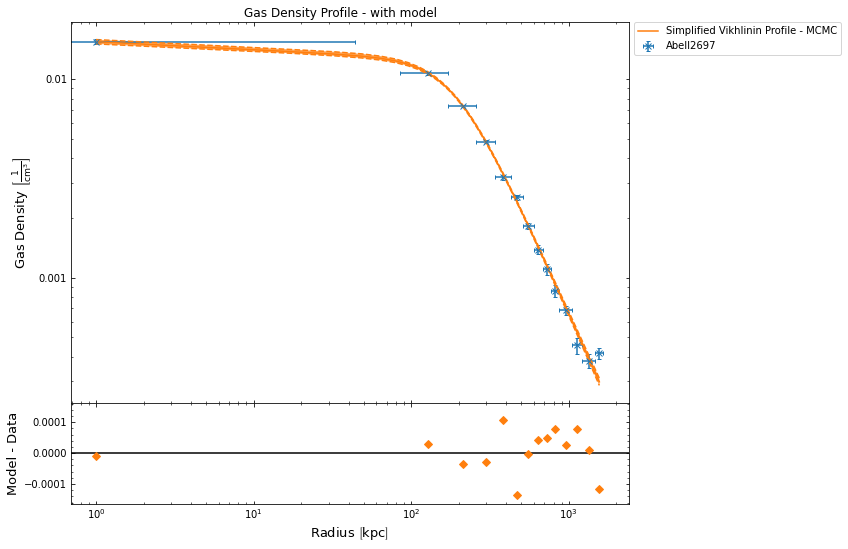

Measuring LoCuSS Gas Masses:   2%|▉                                            | 1/46 [00:40<30:39, 40.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1798.32121649  748.10307018  298.7325556   312.45709299 1303.58074796
  365.87820469]


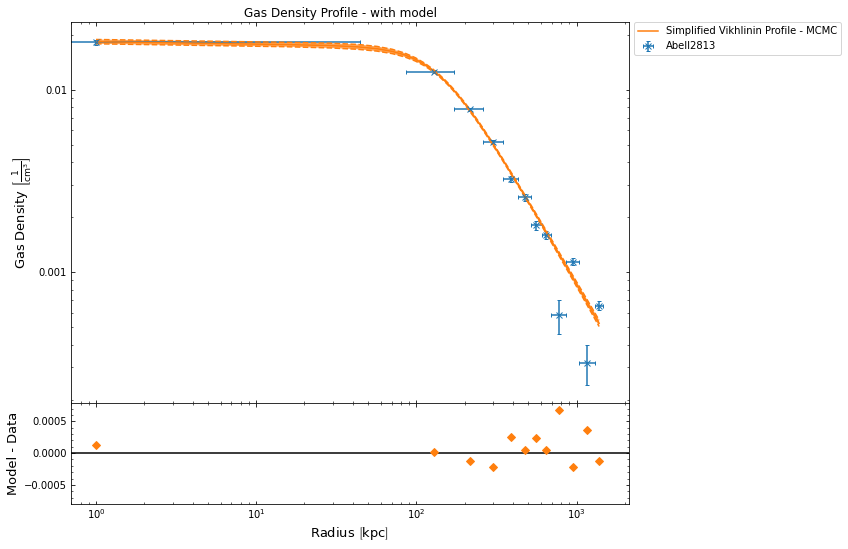

Measuring LoCuSS Gas Masses:   7%|██▉                                          | 3/46 [01:19<17:56, 25.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1471.71463362 2018.15512094 2172.77709439 3065.96030045 1797.70720611
 2456.71349471]


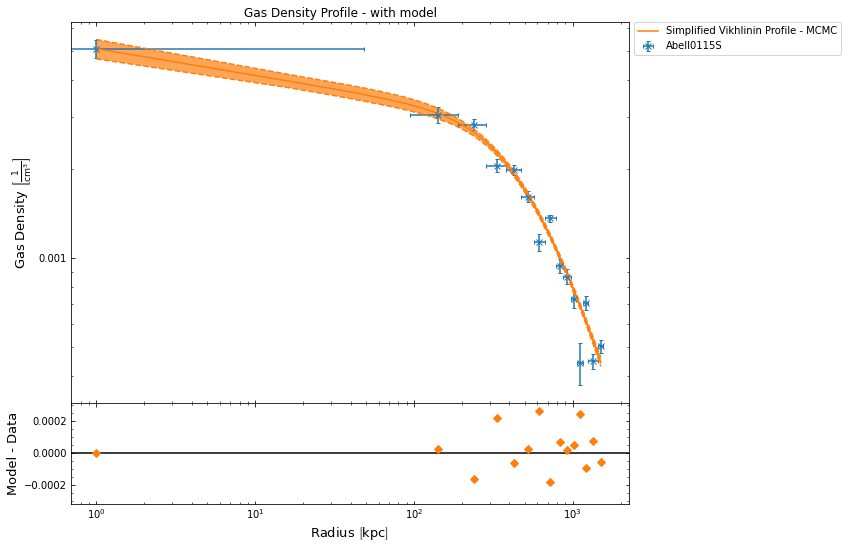

Measuring LoCuSS Gas Masses:   9%|███▉                                         | 4/46 [01:59<20:56, 29.92s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [508.53337047 552.25470482 817.5656657  815.25169716 537.20321617
 804.23174118]


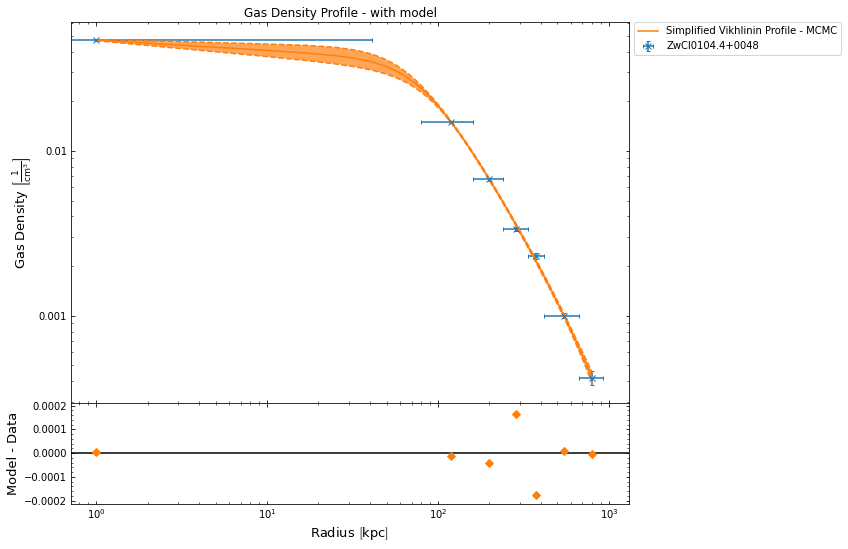

Measuring LoCuSS Gas Masses:  13%|█████▊                                       | 6/46 [02:40<16:57, 25.44s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 543.59895226 1397.37067179 1137.16947861 1352.75279379 1152.53800028
 1094.8797391 ]


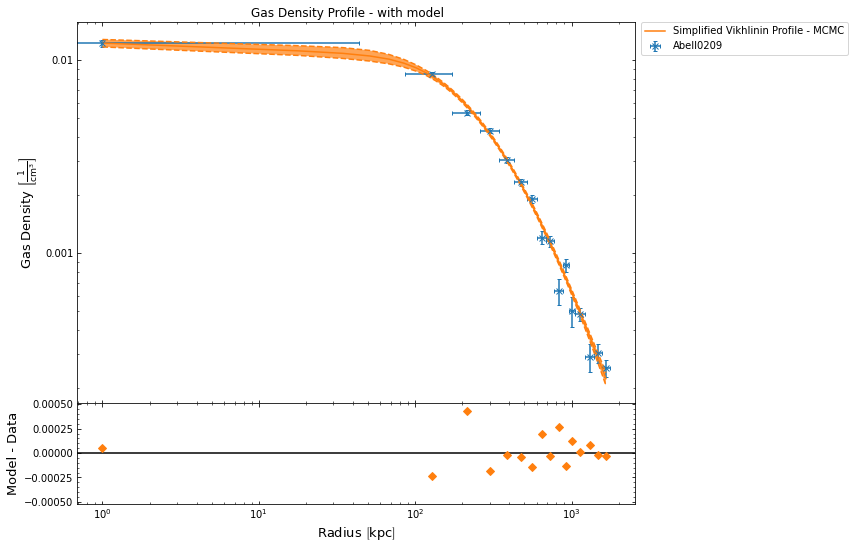

Measuring LoCuSS Gas Masses:  15%|██████▊                                      | 7/46 [03:25<19:50, 30.52s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1424.4453128   909.12339341  363.26208192  451.48318647 1480.57975284
  614.06827077]


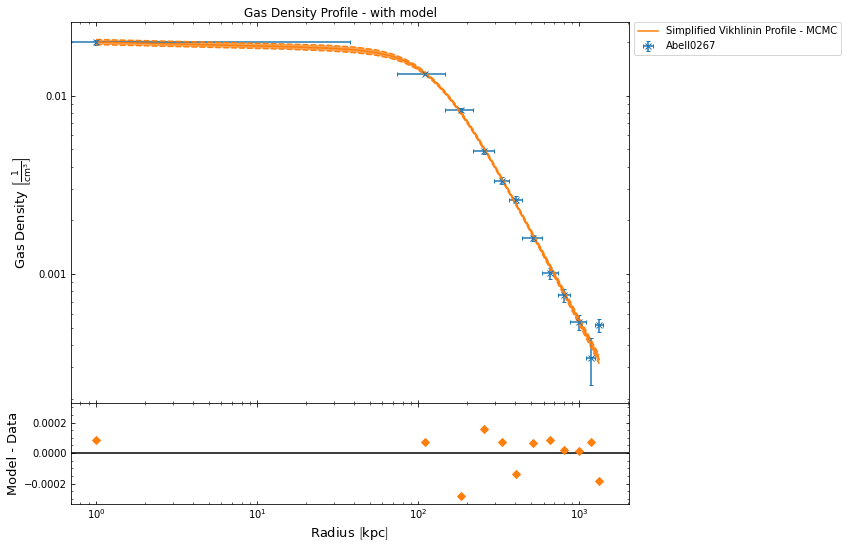

Measuring LoCuSS Gas Masses:  17%|███████▊                                     | 8/46 [04:05<20:52, 32.95s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:965: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:779: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [543.91071175 298.68453728 261.92682762 687.36735761 212.70723406
 318.08776197]


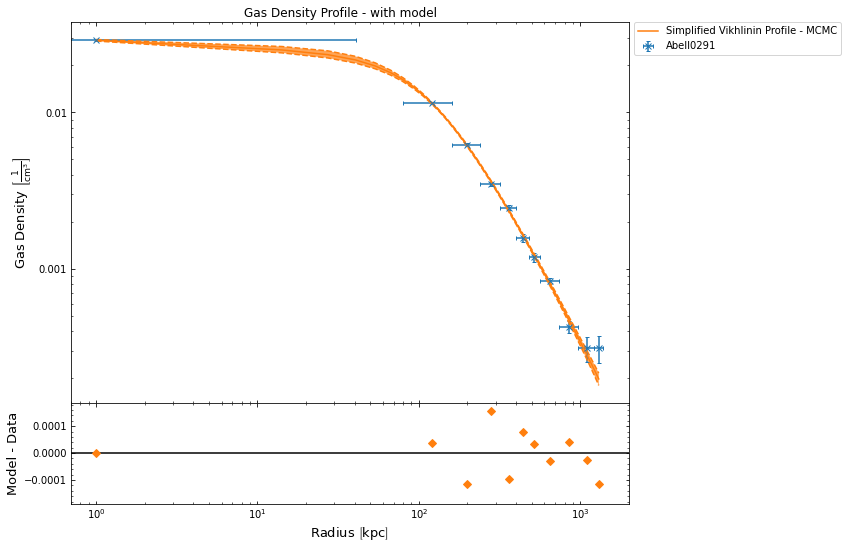

Measuring LoCuSS Gas Masses:  20%|████████▊                                    | 9/46 [04:45<21:38, 35.09s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2803.46852538 2492.05601558 2458.13258478 2814.33256737 2493.0087231
 2374.1863595 ]


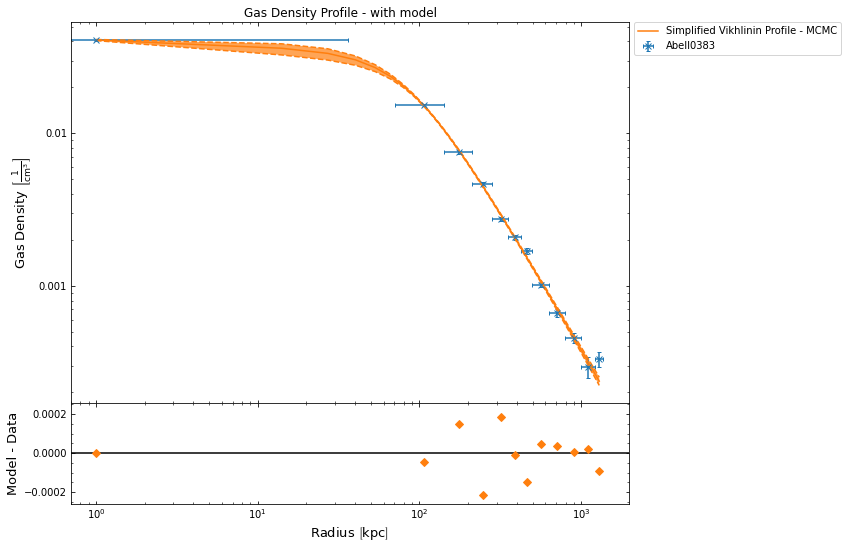

Measuring LoCuSS Gas Masses:  22%|█████████▌                                  | 10/46 [05:25<21:52, 36.47s/it]

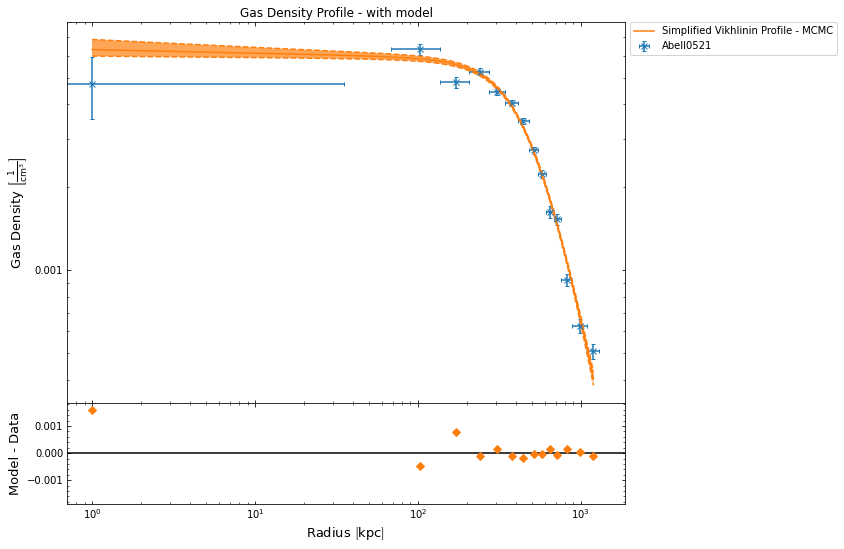

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:463: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  warn("The outer radius you supplied is greater than or equal to the outer radius covered by the data, so"
Measuring LoCuSS Gas Masses:  24%|██████████▌                                 | 11/46 [06:03<21:35, 37.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2241.37470207 1383.24705352 1619.78677644 1046.05803149 2107.19631678
 2004.31810004]


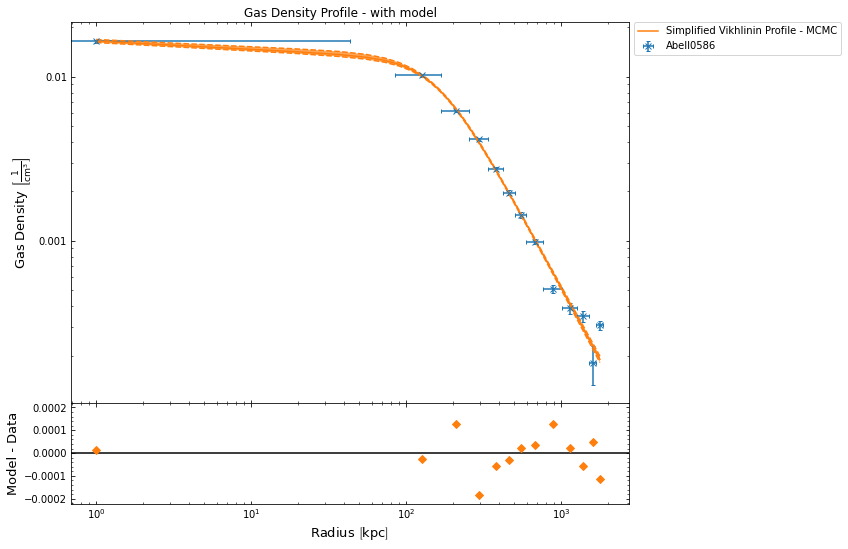

Measuring LoCuSS Gas Masses:  26%|███████████▍                                | 12/46 [06:43<21:26, 37.85s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1905.88877689 2169.45408358 3306.60550818 3042.53971219 1650.39915603
 3257.10044228]


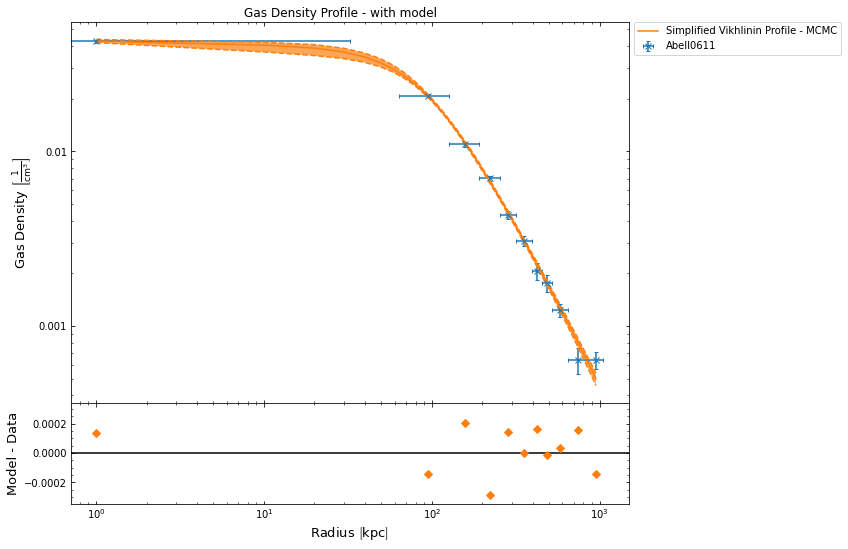

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:463: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  warn("The outer radius you supplied is greater than or equal to the outer radius covered by the data, so"
Measuring LoCuSS Gas Masses:  28%|████████████▍                               | 13/46 [07:21<20:46, 37.76s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2252.42074955  624.12461038  207.04056579  254.05305855 1184.08720795
  444.0739792 ]


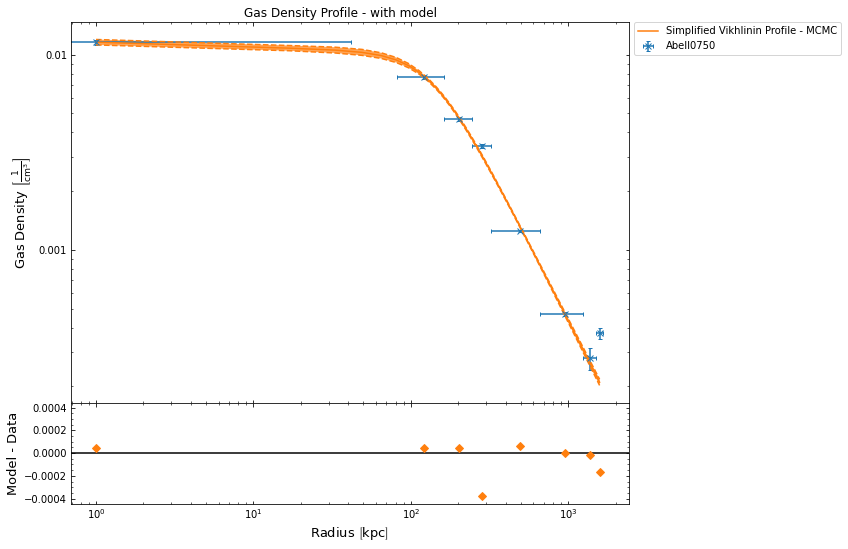

Measuring LoCuSS Gas Masses:  35%|███████████████▎                            | 16/46 [08:00<11:56, 23.87s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/emcee-3.1.1-py3.8.egg/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [         nan 382.57905328 733.78579924 155.23423574 154.1967097
 203.91549902]


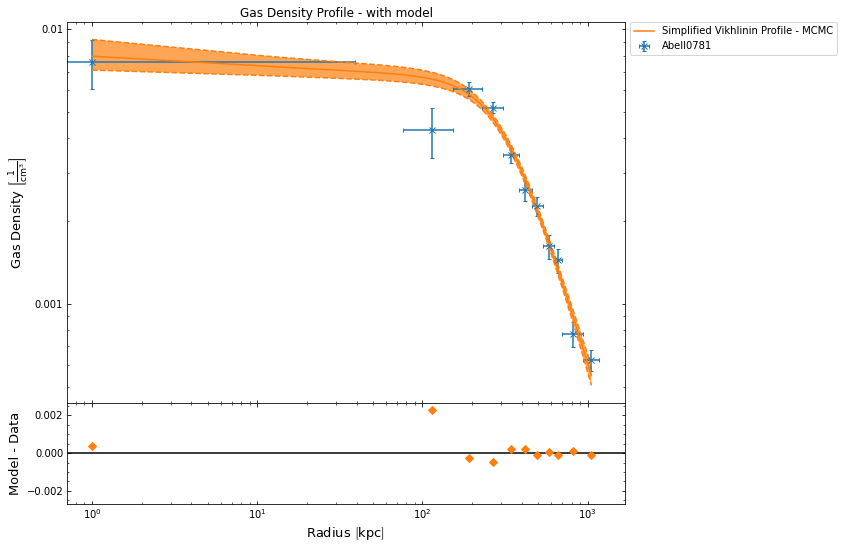

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:463: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  warn("The outer radius you supplied is greater than or equal to the outer radius covered by the data, so"
Measuring LoCuSS Gas Masses:  39%|█████████████████▏                          | 18/46 [08:38<10:21, 22.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [165.32522871 175.03007748 734.43323234 686.02517765 267.2765168
 742.4998578 ]


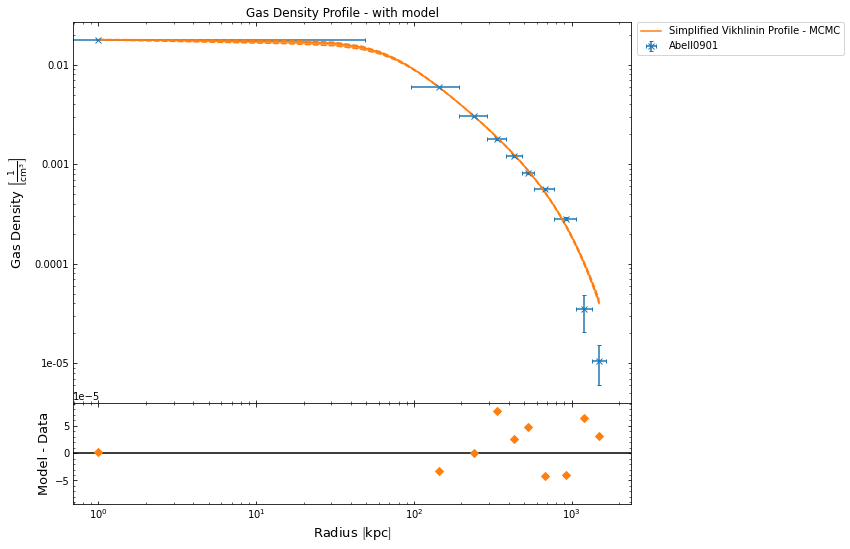

Measuring LoCuSS Gas Masses:  41%|██████████████████▏                         | 19/46 [09:20<11:48, 26.22s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1141.72825565 1094.24429761  441.73258751  603.61771183 1302.38077213
 1055.52471424]


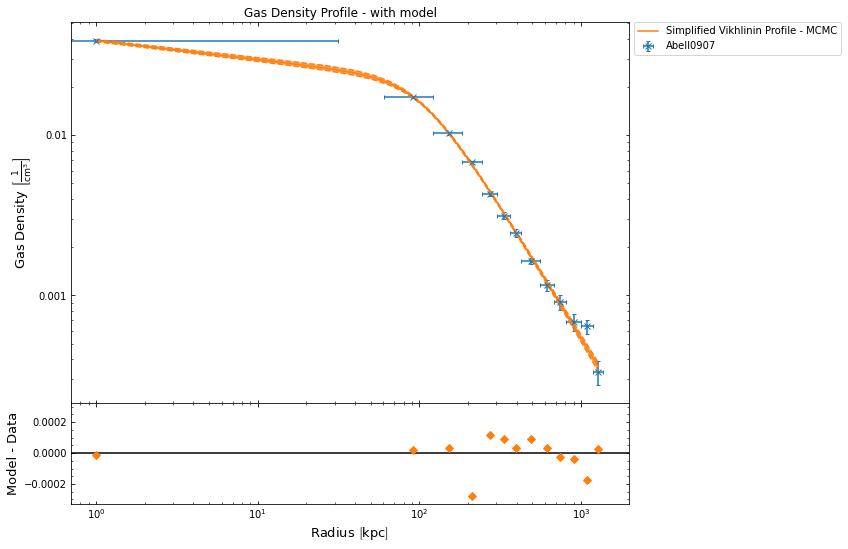

Measuring LoCuSS Gas Masses:  43%|███████████████████▏                        | 20/46 [10:02<12:50, 29.63s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2439.10169379 1028.25925713  448.50605838  634.17114264 1794.48836444
  758.27816689]


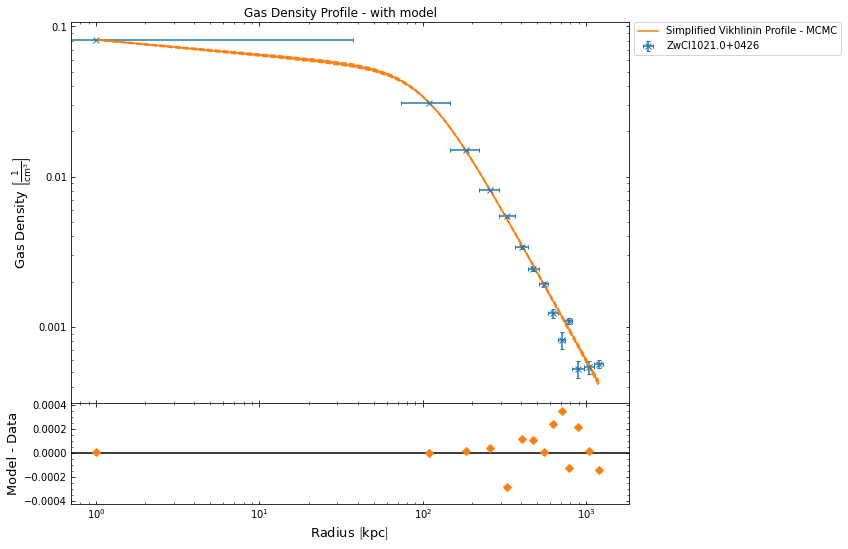

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:463: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  warn("The outer radius you supplied is greater than or equal to the outer radius covered by the data, so"
Measuring LoCuSS Gas Masses:  48%|█████████████████████                       | 22/46 [10:46<10:41, 26.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1518.33169004  533.15571294  310.91938302  501.83114587 1305.3616595
  658.4890437 ]


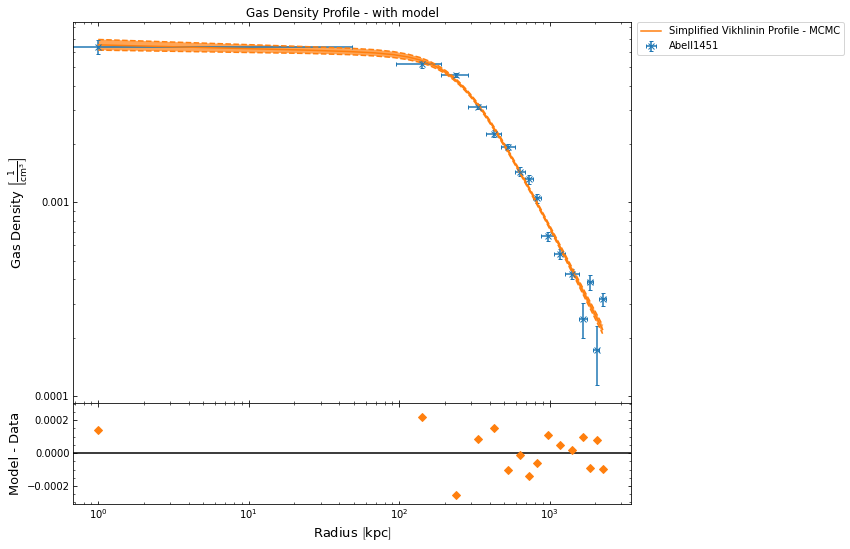

Measuring LoCuSS Gas Masses:  50%|██████████████████████                      | 23/46 [11:25<11:17, 29.46s/it]

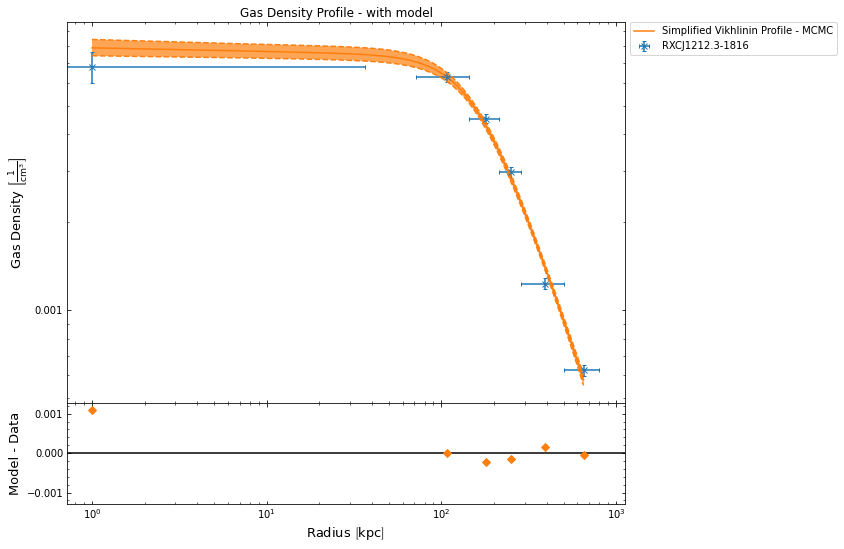

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:463: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  warn("The outer radius you supplied is greater than or equal to the outer radius covered by the data, so"
Measuring LoCuSS Gas Masses:  52%|██████████████████████▉                     | 24/46 [12:03<11:31, 31.44s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2490.39116315 1847.14629587 1443.86306457 1091.34899944 2363.30278117
 2128.53298531]


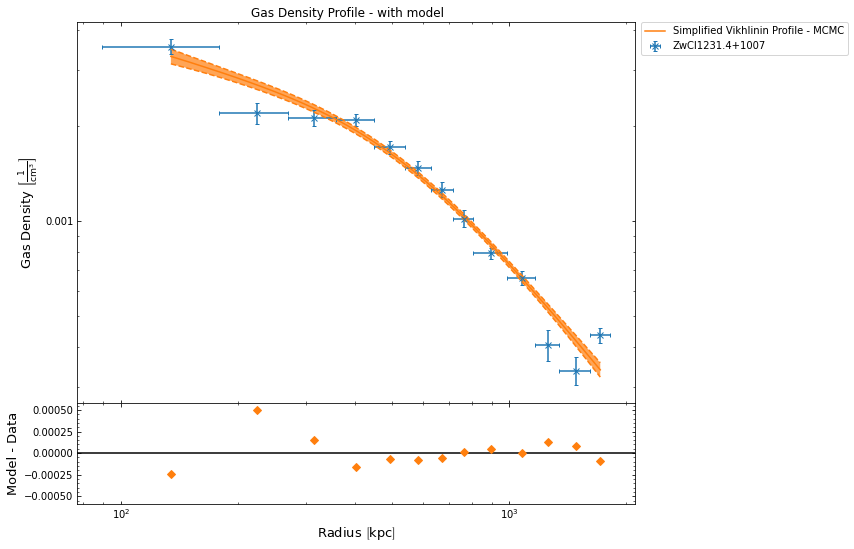

Measuring LoCuSS Gas Masses:  54%|███████████████████████▉                    | 25/46 [12:46<12:00, 34.31s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 576.11744413  608.98194038 1198.10451071  923.85541916  625.14253461
 1236.79491972]


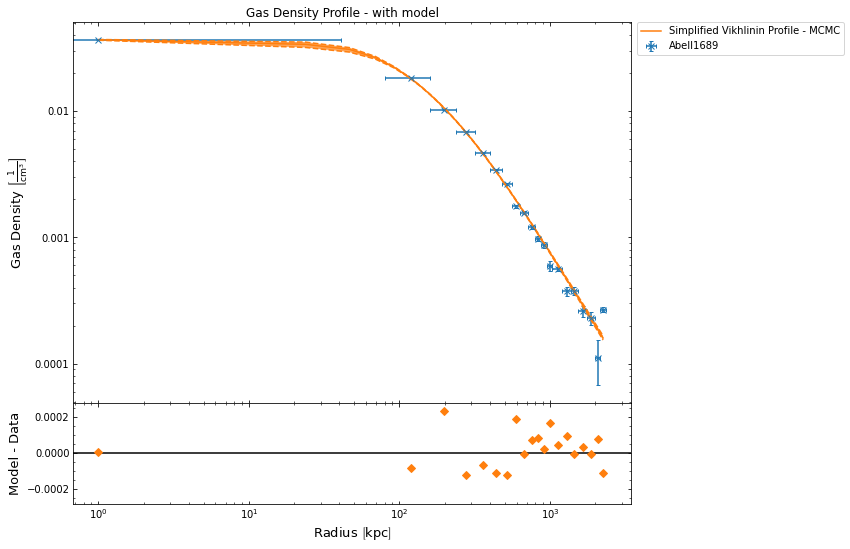

Measuring LoCuSS Gas Masses:  57%|████████████████████████▊                   | 26/46 [13:33<12:34, 37.70s/it]

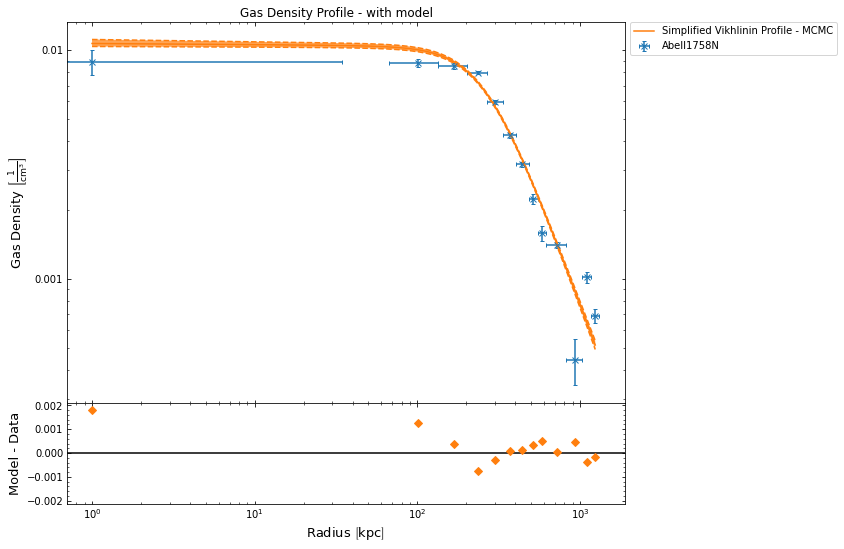

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:463: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  warn("The outer radius you supplied is greater than or equal to the outer radius covered by the data, so"
Measuring LoCuSS Gas Masses:  59%|█████████████████████████▊                  | 27/46 [14:12<12:03, 38.07s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1762.27346882  815.34024579  502.72216013  516.07852052 1701.39294931
  943.70244442]


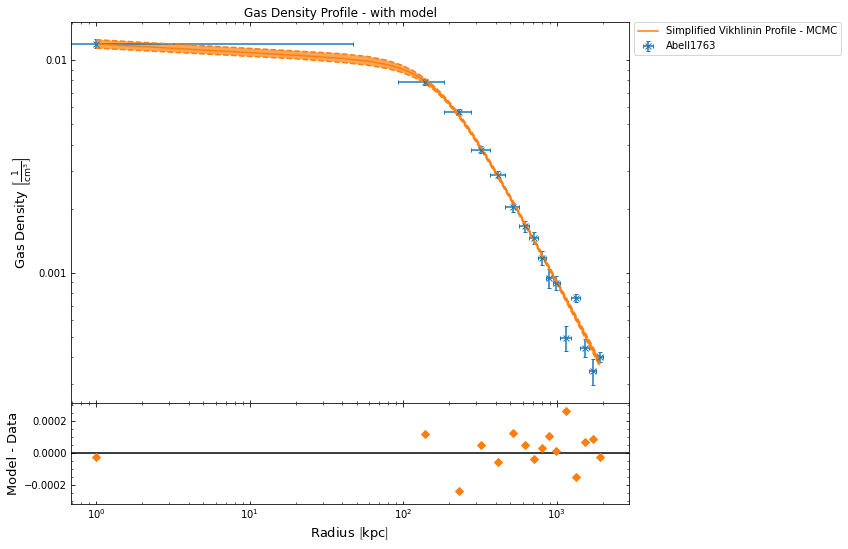

Measuring LoCuSS Gas Masses:  61%|██████████████████████████▊                 | 28/46 [14:52<11:35, 38.62s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1325.59954929 1607.45742655 2075.67268548 1818.63301208 1492.17199276
 2093.47194318]


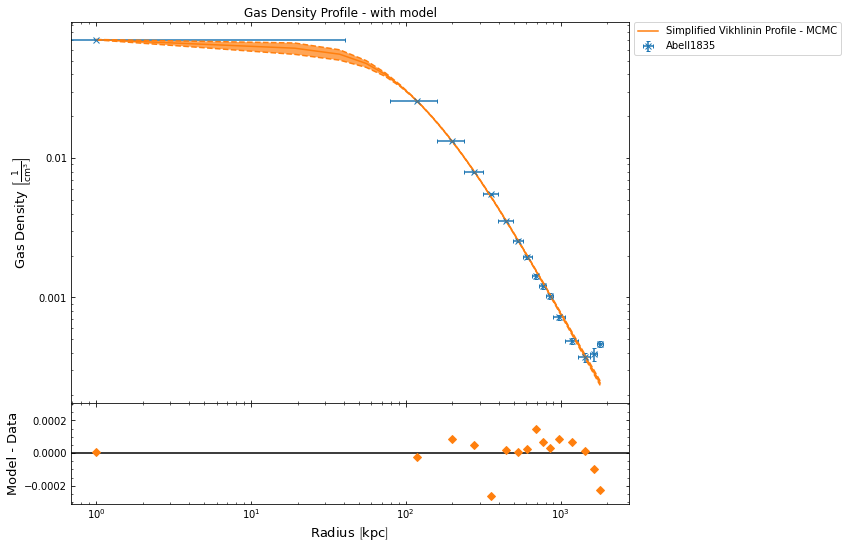

Measuring LoCuSS Gas Masses:  63%|███████████████████████████▋                | 29/46 [15:39<11:38, 41.08s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 279.53725471  370.24945827 1256.46473611 1073.24090488  211.46767655
 1276.55408808]


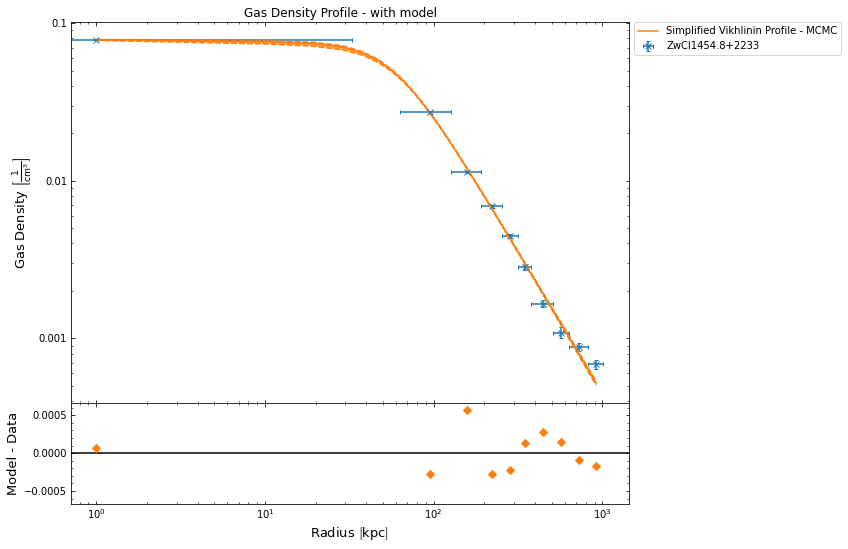

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:463: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  warn("The outer radius you supplied is greater than or equal to the outer radius covered by the data, so"
Measuring LoCuSS Gas Masses:  67%|█████████████████████████████▋              | 31/46 [16:20<07:55, 31.71s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1658.71803752 1676.44205095 1448.7526923  1471.15445395 1868.71687934
 1544.42182801]


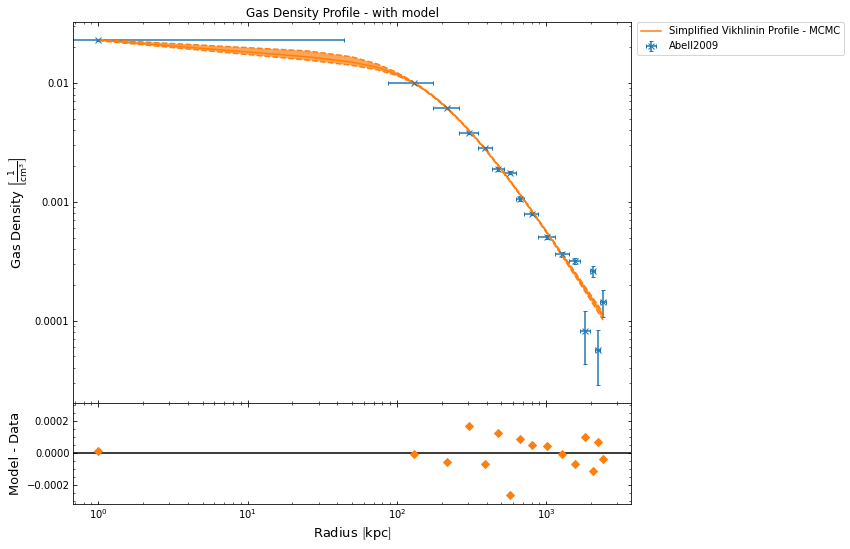

Measuring LoCuSS Gas Masses:  70%|██████████████████████████████▌             | 32/46 [17:06<08:14, 35.30s/it]

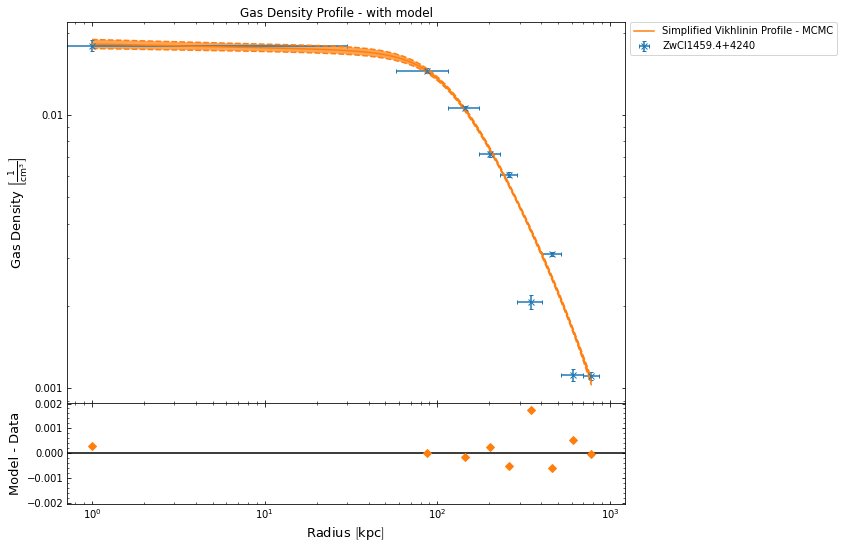

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:463: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  warn("The outer radius you supplied is greater than or equal to the outer radius covered by the data, so"
Measuring LoCuSS Gas Masses:  72%|███████████████████████████████▌            | 33/46 [17:47<07:57, 36.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2483.13356466 2201.02979051 3186.71199842 2637.80242541 2491.0097899
 3122.64778646]


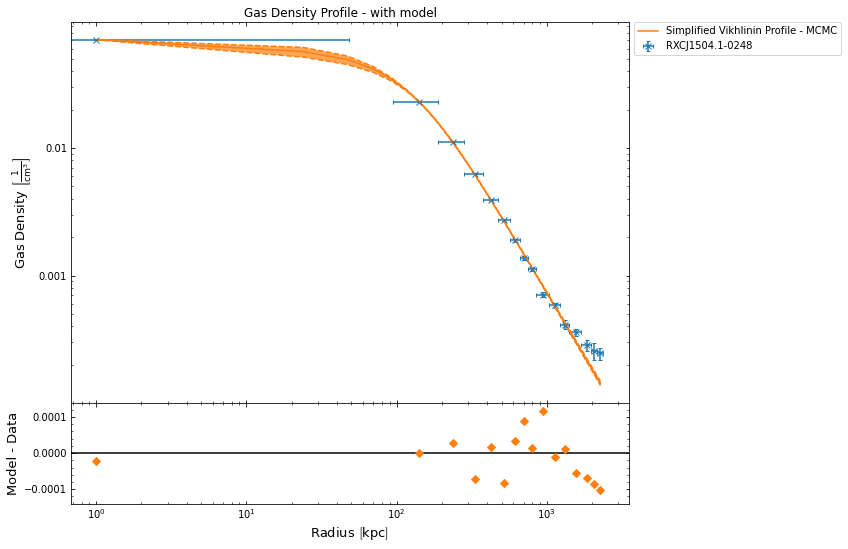

Measuring LoCuSS Gas Masses:  74%|████████████████████████████████▌           | 34/46 [18:32<07:46, 38.91s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1962.9724456   920.34364147  366.7561786   552.54579402 1617.07957175
  653.33888039]


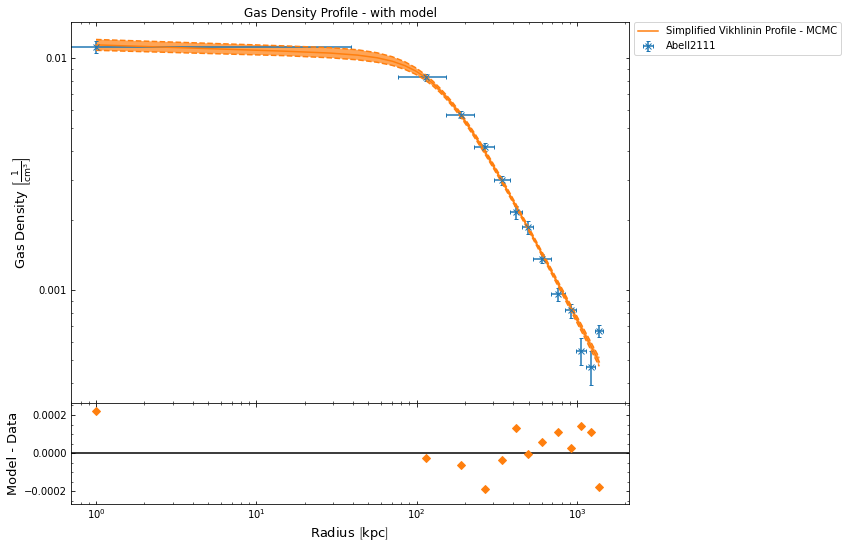

Measuring LoCuSS Gas Masses:  76%|█████████████████████████████████▍          | 35/46 [19:11<07:07, 38.89s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2246.56541383 3169.04978846 3729.3980711  3736.00888142 3212.6902096
 3803.98780498]


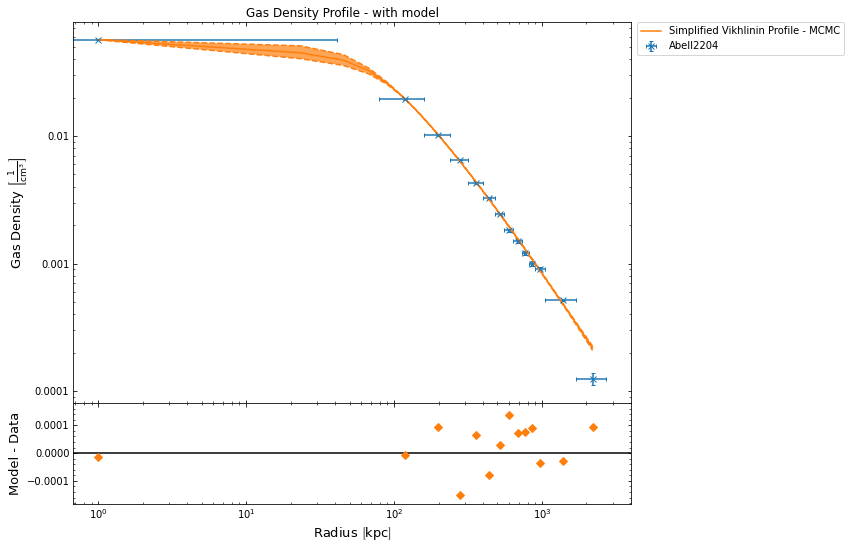

Measuring LoCuSS Gas Masses:  78%|██████████████████████████████████▍         | 36/46 [19:58<06:51, 41.15s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1963.93770332 1761.09813822 1881.25243615 1365.32335868 2038.7235495
 2450.07077957]


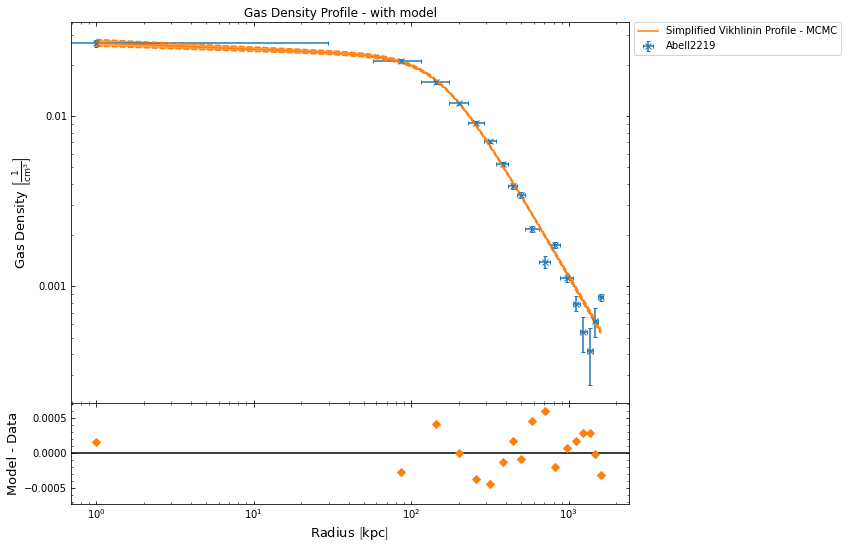

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:463: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  warn("The outer radius you supplied is greater than or equal to the outer radius covered by the data, so"
Measuring LoCuSS Gas Masses:  80%|███████████████████████████████████▍        | 37/46 [20:40<06:13, 41.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1184.50544838  968.79061226  381.14921171  437.8577741   805.330572
 1306.50211385]


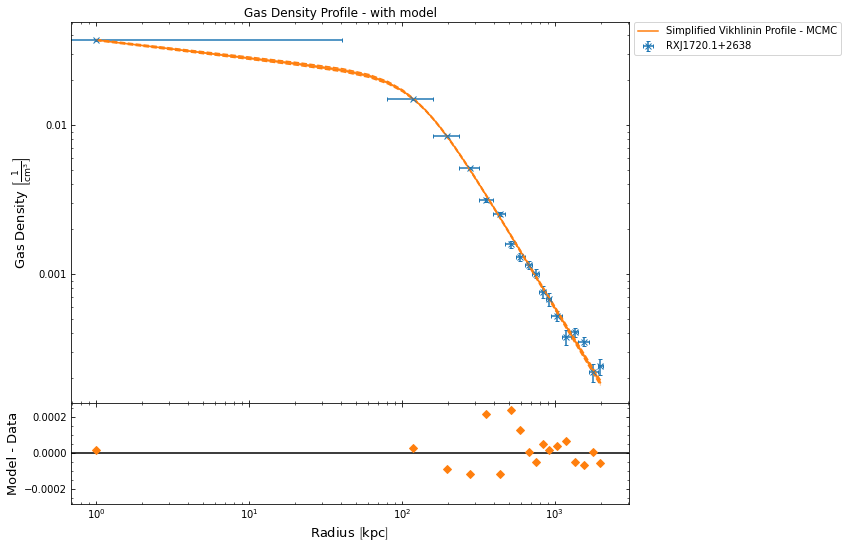

Measuring LoCuSS Gas Masses:  83%|████████████████████████████████████▎       | 38/46 [21:24<05:37, 42.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 203.93122555  258.1400537   939.13517938  687.16413767  226.07037986
 1045.11738703]


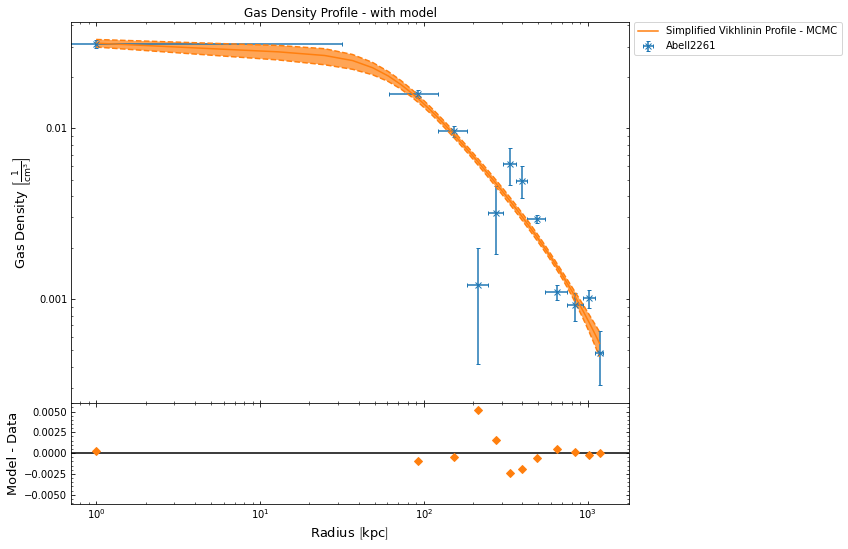

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:463: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  warn("The outer radius you supplied is greater than or equal to the outer radius covered by the data, so"
Measuring LoCuSS Gas Masses:  85%|█████████████████████████████████████▎      | 39/46 [22:06<04:55, 42.28s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1049.19824977  936.39879911  745.89799753  755.9918892   960.58726443
  788.79535677]


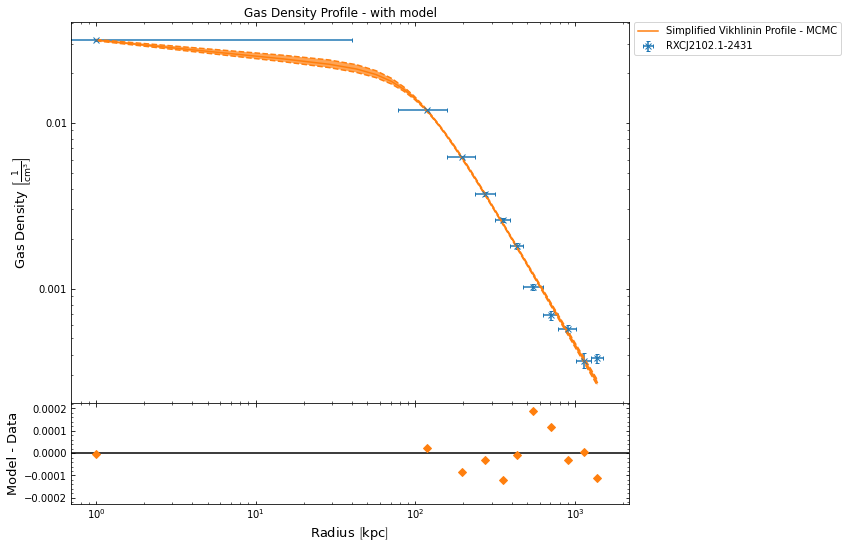

Measuring LoCuSS Gas Masses:  87%|██████████████████████████████████████▎     | 40/46 [22:49<04:14, 42.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1956.20551514 3215.99475791 2712.37551354 2856.5451027  3262.71244913
 3011.19388914]


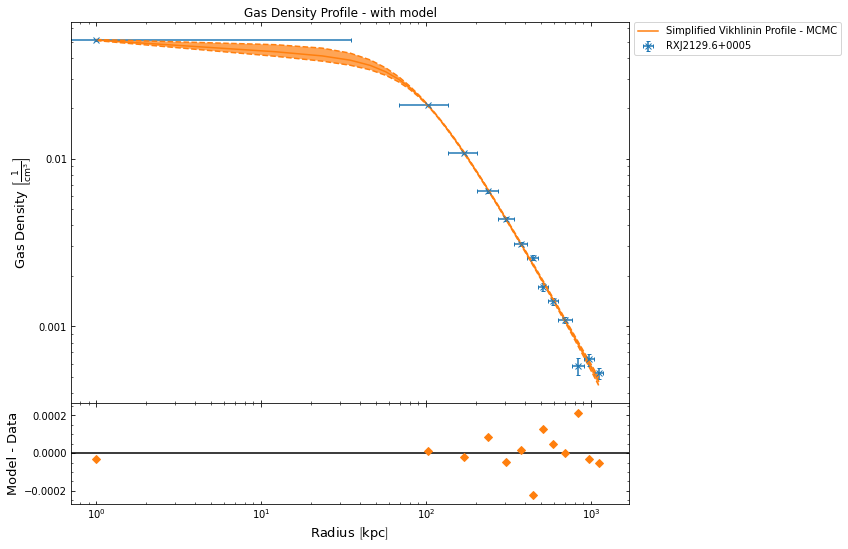

Measuring LoCuSS Gas Masses:  89%|███████████████████████████████████████▏    | 41/46 [23:32<03:32, 42.40s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1100.19870858 1199.26705475 1483.10364415 1484.12266668 1212.18066806
 1411.87539566]


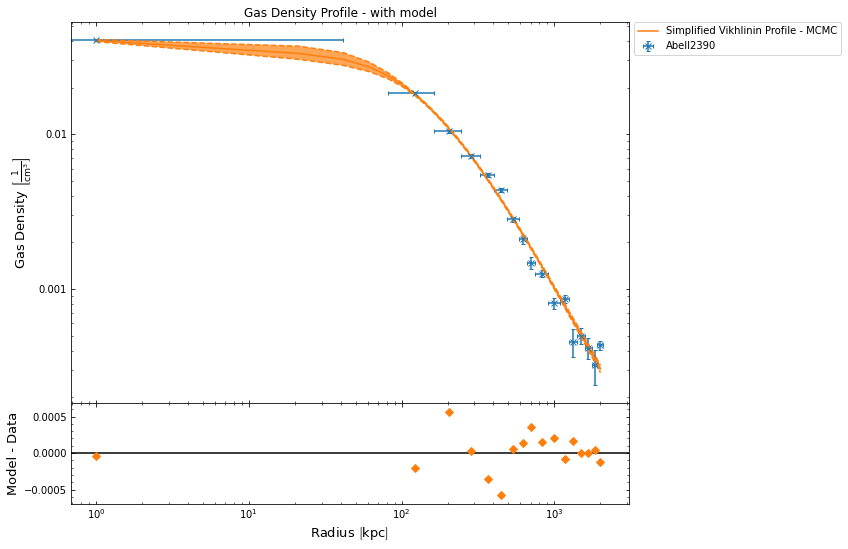

Measuring LoCuSS Gas Masses:  91%|████████████████████████████████████████▏   | 42/46 [24:18<02:54, 43.68s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [3458.36914601  310.98598432  487.64494897  326.78432326 2773.89005739
  313.99994112]


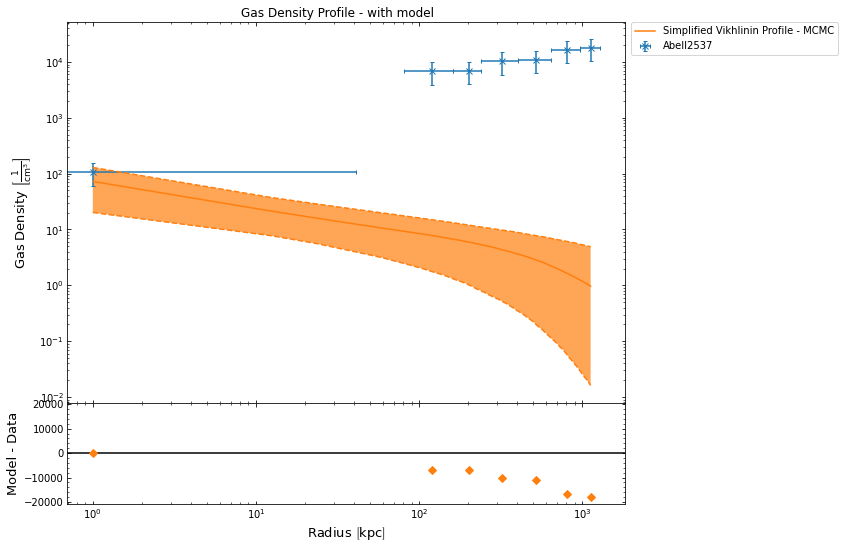

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:463: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  warn("The outer radius you supplied is greater than or equal to the outer radius covered by the data, so"
Measuring LoCuSS Gas Masses:  93%|█████████████████████████████████████████▏  | 43/46 [25:00<02:09, 43.12s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 431.27474701  833.14783604 1633.72975039 1512.8378206  1466.6634393
 1690.39808925]


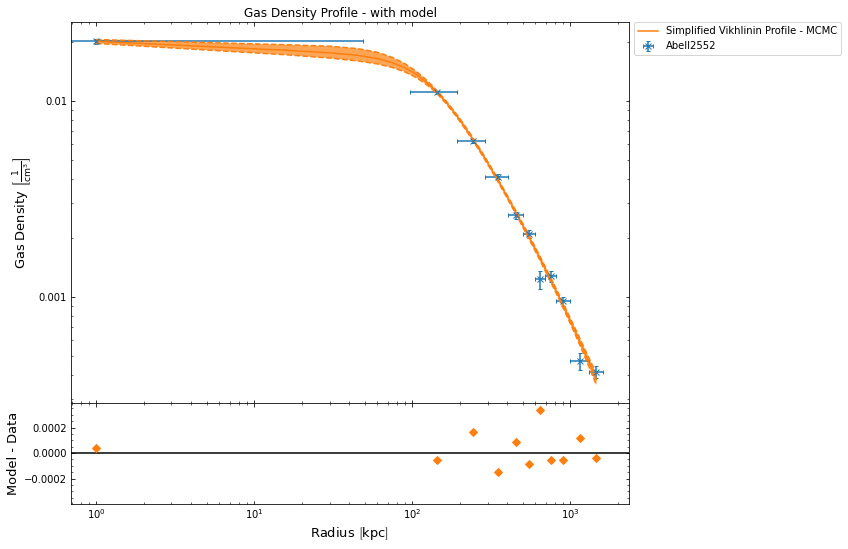

Measuring LoCuSS Gas Masses:  96%|██████████████████████████████████████████  | 44/46 [25:42<01:25, 42.66s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [735.71284523 829.41395363 404.27008055 612.47879595 903.34790136
 909.004476  ]


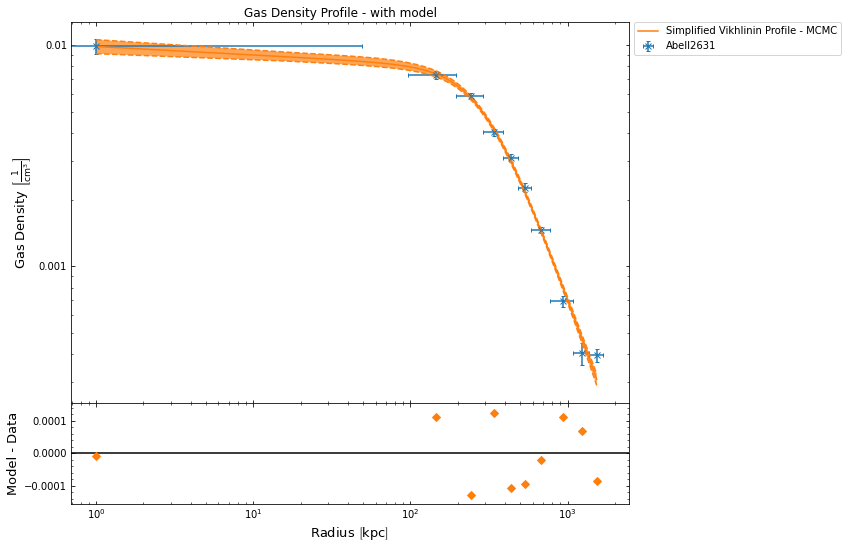

Measuring LoCuSS Gas Masses:  98%|███████████████████████████████████████████ | 45/46 [26:21<00:41, 41.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1074.05929385 1516.47955438 3207.78773896 1489.81870677 1534.04405088
 2182.74954391]


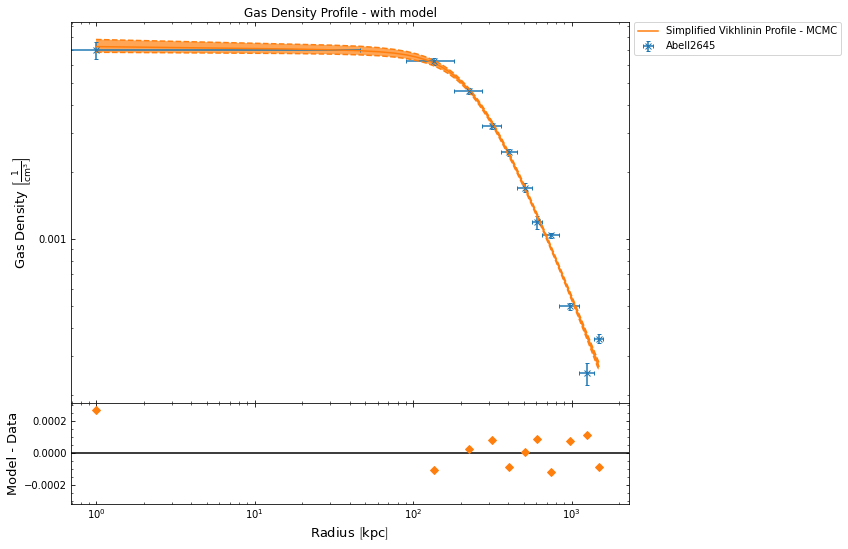

Measuring LoCuSS Gas Masses: 100%|████████████████████████████████████████████| 46/46 [26:59<00:00, 35.21s/it]


In [32]:
dpath = "non_paper_figures/density_profiles/svikh_13r500_annspec/"
if not os.path.exists(dpath):
    os.makedirs(dpath+"lovisari")
    os.makedirs(dpath+"locuss") 

lov_svikh_13_annspec_gm = []
with tqdm(desc="Measuring Lovisari Gas Masses", total=len(lov_annspec_13_dp)) as onwards:
    for dp in lov_annspec_13_dp:
        if dp is not None:
            rel_src = lovisari_srcs[dp.src_name]
            # Fit a simplified Vikhlinin density profile
            dp.fit("simple_vikhlinin_dens", progress_bar=False)
            dp.view(save_path=dpath+"lovisari/{}.pdf".format(rel_src.name))
            try:
                # Measure a gas mass within R500
                gm = dp.gas_mass("simple_vikhlinin_dens", rel_src.r500)[0]
                lov_svikh_13_annspec_gm.append(gm)
            except ModelNotAssociatedError:
                lov_svikh_13_annspec_gm.append([np.NaN, np.NaN, np.NaN])
        else:
            lov_svikh_13_annspec_gm.append([np.NaN, np.NaN, np.NaN])
    
        onwards.update(1)

loc_svikh_13_annspec_gm = []
with tqdm(desc="Measuring LoCuSS Gas Masses", total=len(loc_annspec_13_dp)) as onwards:
    for dp in loc_annspec_13_dp:
        if dp is not None:
            rel_src = locuss_srcs[dp.src_name]
            # Fit a simplified Vikhlinin density profile
            dp.fit("simple_vikhlinin_dens", progress_bar=False)
            dp.view(save_path=dpath+"locuss/{}.pdf".format(rel_src.name))
            try:
                # Measure a gas mass within R500
                gm = dp.gas_mass("simple_vikhlinin_dens", rel_src.r500)[0]
                loc_svikh_13_annspec_gm.append(gm)
            except ModelNotAssociatedError:
                loc_svikh_13_annspec_gm.append([np.NaN, np.NaN, np.NaN])
        else:
            loc_svikh_13_annspec_gm.append([np.NaN, np.NaN, np.NaN])
    
        onwards.update(1)

lov_svikh_13_annspec_gm = Quantity(lov_svikh_13_annspec_gm, 'Msun').astype(float)
loc_svikh_13_annspec_gm = Quantity(loc_svikh_13_annspec_gm, 'Msun').astype(float)

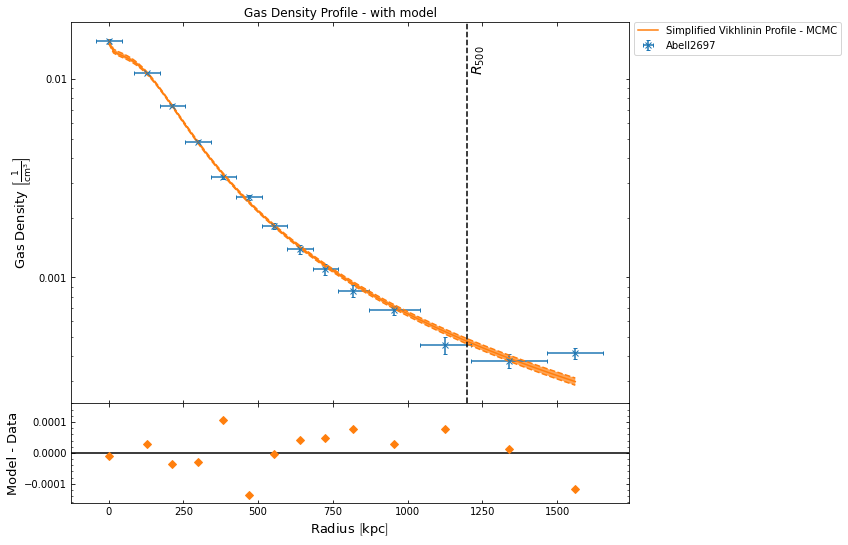

In [65]:
rel_src = locuss_srcs[loc_annspec_13_dp[0].src_name]
loc_annspec_13_dp[0].view(draw_rads={'$R_{500}$': rel_src.r500}, xscale='linear')

/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


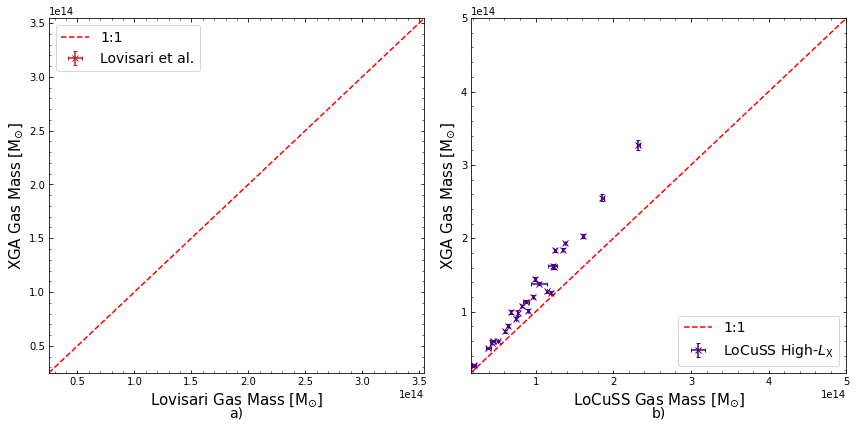

In [69]:
# Setting the y-position and font size of the a and b  labels that are added below the subplots
sublabel_ypos = -0.115
sublabel_fsize = 14

# Set up the matplotlib figure with 2 columns, meaning three subplots
fig, ax_arr = plt.subplots(ncols=2, figsize=(12, 6))

# Iterating through the array of axes objects, setting up the ticks
for ax in ax_arr:
    ax.minorticks_on()
    ax.tick_params(which='both', top=True, right=True, direction='in')

# Reading out the first axis in the array of axes
ax = ax_arr[0]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
lov_lims = find_lims(lov_lit_gms, lov_svikh_13_annspec_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(lov_lims, lov_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(lov_lit_gms[:, 0].value, lov_svikh_13_annspec_gm[:, 0].value, 
             xerr=lov_lit_gms[:, 1:].T.value, 
             yerr=lov_svikh_13_annspec_gm[:, 1:].T.value, fmt='x', 
             color=lov_colour, capsize=2, label="Lovisari et al.")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"Lovisari Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(lov_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(lov_lims)
ax.text(0.5, sublabel_ypos, s='a)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Reading out the second axis in the array of axes
ax = ax_arr[1]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
loc_lims = find_lims(loc_lit_gms, loc_svikh_13_annspec_gm).value
loc_lims[1] = 0.5e+15
# Plotting a 1:1 line to help with comparisons
plt.plot(loc_lims, loc_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(loc_lit_gms[:, 0].value, loc_svikh_13_annspec_gm[:, 0].value, 
             xerr=loc_lit_gms[:, 1].value, 
             yerr=loc_svikh_13_annspec_gm[:, 1:].T.value, fmt='x', 
             color=loc_colour, capsize=2, label=r"LoCuSS High-$L_{\rm{X}}$")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"LoCuSS Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(loc_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(loc_lims)
ax.text(0.5, sublabel_ypos, s='b)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Saving and plotting the resulting figure
plt.tight_layout()
plt.savefig("non_paper_figures/lov_loc_svikh_13r500_annspec_gm_comp.pdf")
plt.show()

### Simplified Vikhlinin Profiles - out to 1.2$R_{500}$ 

In [ ]:
loc_annspec_12_dp = ann_spectra_apec_norm(locuss_srcs, locuss_srcs.r500*1.2, min_snr=30)
lov_annspec_12_dp = ann_spectra_apec_norm(lovisari_srcs, lovisari_srcs.r500*1.2, min_snr=30)

In [35]:
lov_annspec_12_dp = [None]*len(lovisari_srcs)

Measuring LoCuSS Gas Masses:   0%|                                                     | 0/46 [00:00<?, ?it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1726.39132394  977.06814412  849.71280945  832.79056621 1621.92088162
 1351.15456364]


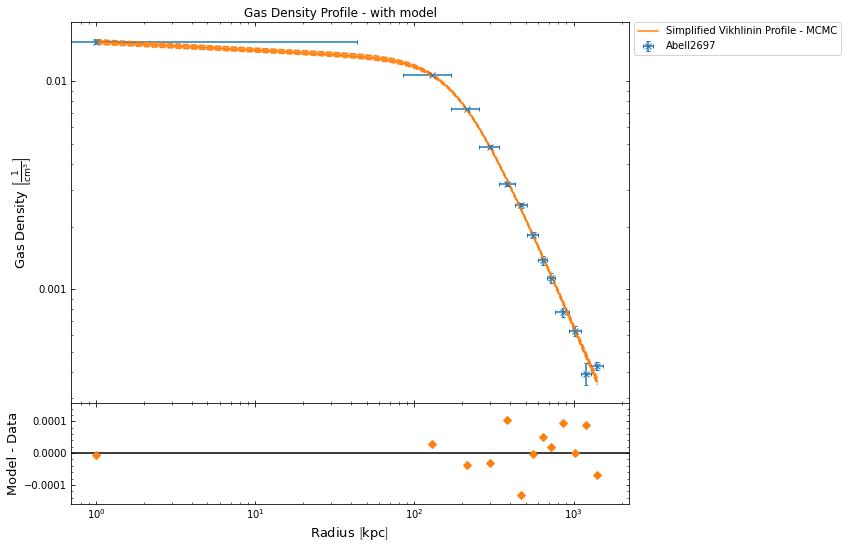

Measuring LoCuSS Gas Masses:   2%|▉                                            | 1/46 [00:40<30:14, 40.33s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 191.59767392  616.93889883 1903.98015438  223.55446813  221.78194639
  237.37725924]


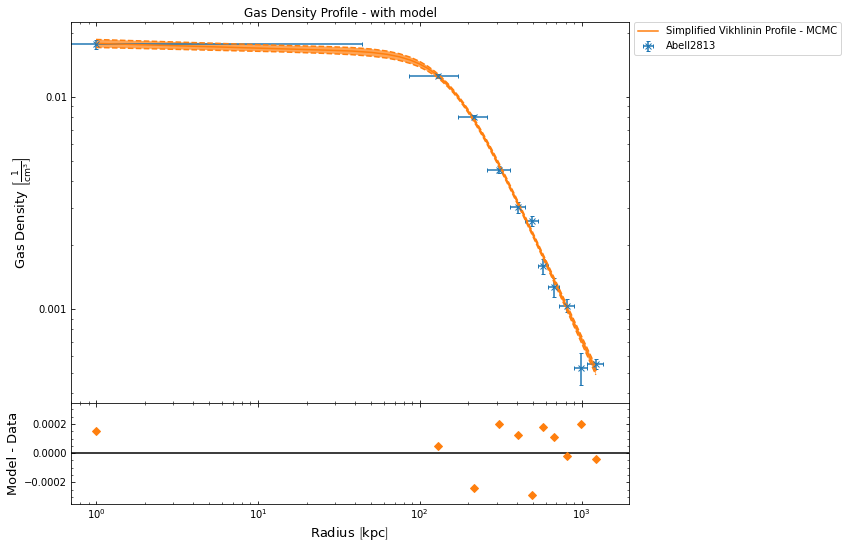

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:463: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  warn("The outer radius you supplied is greater than or equal to the outer radius covered by the data, so"
Measuring LoCuSS Gas Masses:   7%|██▉                                          | 3/46 [01:19<17:48, 24.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1049.32642743 2487.52186014  589.84596838 2474.25248623  863.63699482
 1300.63846272]


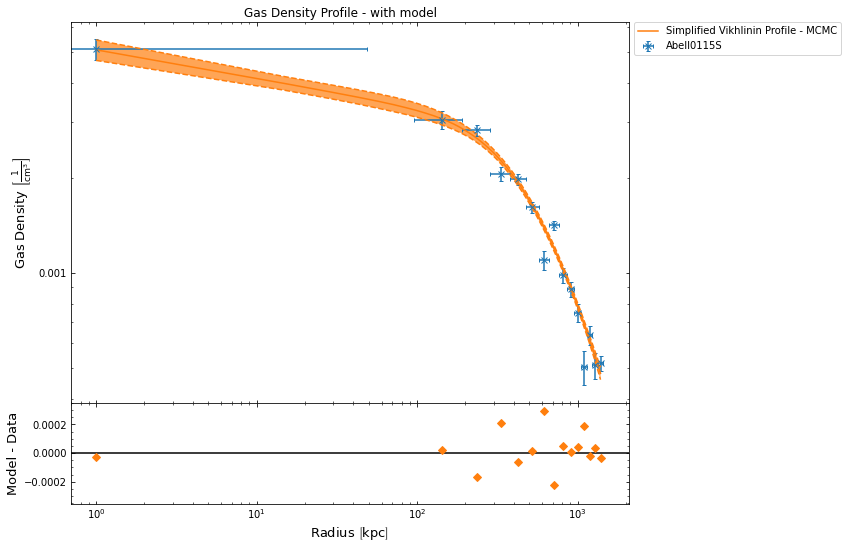

Measuring LoCuSS Gas Masses:   9%|███▉                                         | 4/46 [01:59<21:02, 30.07s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 109.43827849  223.11751384 1239.50398522  109.54769721  135.05477619
  381.52876085]


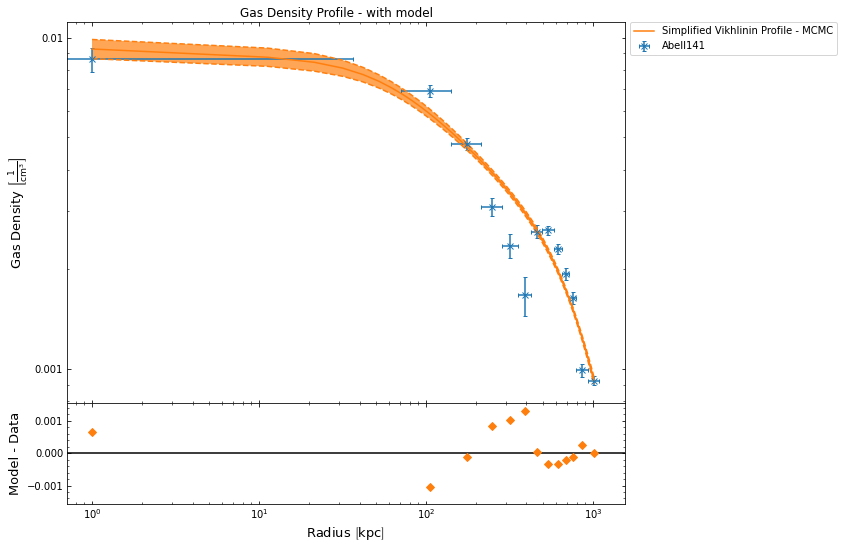

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:463: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  warn("The outer radius you supplied is greater than or equal to the outer radius covered by the data, so"
Measuring LoCuSS Gas Masses:  11%|████▉                                        | 5/46 [02:40<23:09, 33.90s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 750.67275674 1246.14023605 1472.11449273  206.37751531  167.59517975
 1510.83411369]


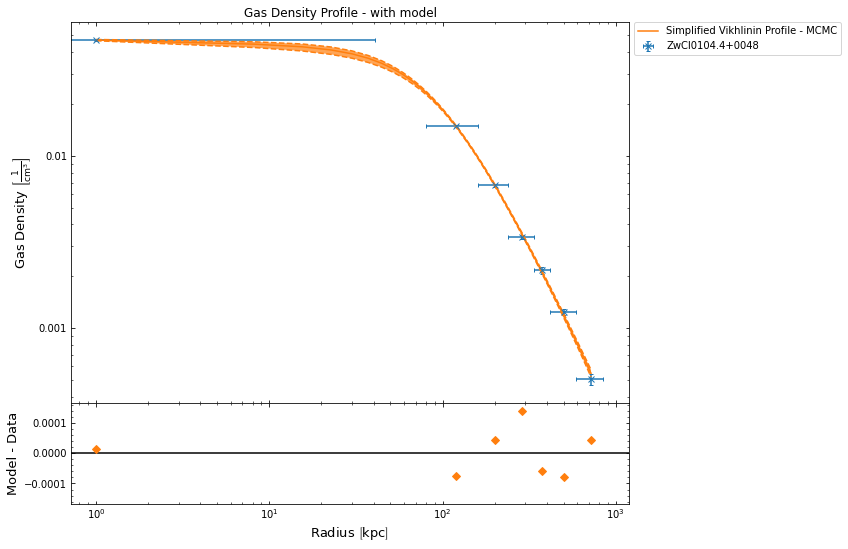

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:463: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  warn("The outer radius you supplied is greater than or equal to the outer radius covered by the data, so"
Measuring LoCuSS Gas Masses:  13%|█████▊                                       | 6/46 [03:20<23:55, 35.88s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1243.37518376 2621.17766274 1733.14998295 2764.38424936 1478.55785281
 1805.445481  ]


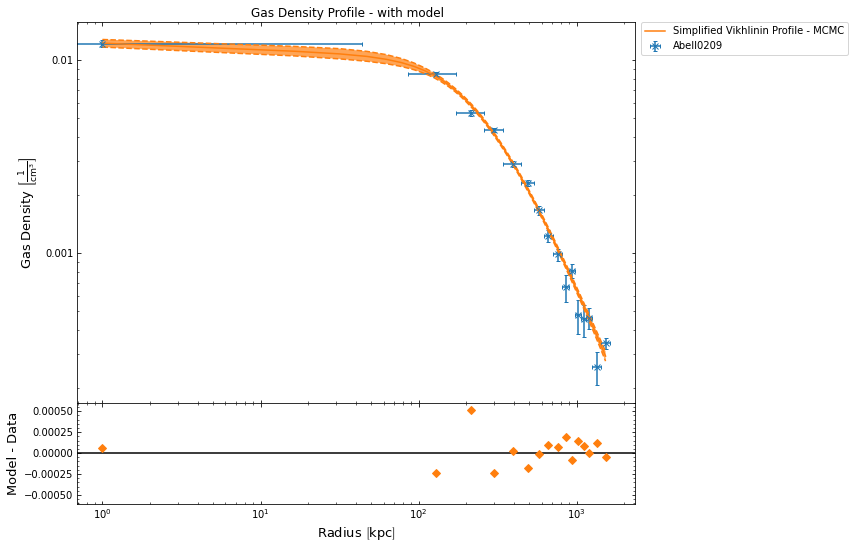

Measuring LoCuSS Gas Masses:  15%|██████▊                                      | 7/46 [04:01<24:17, 37.38s/it]

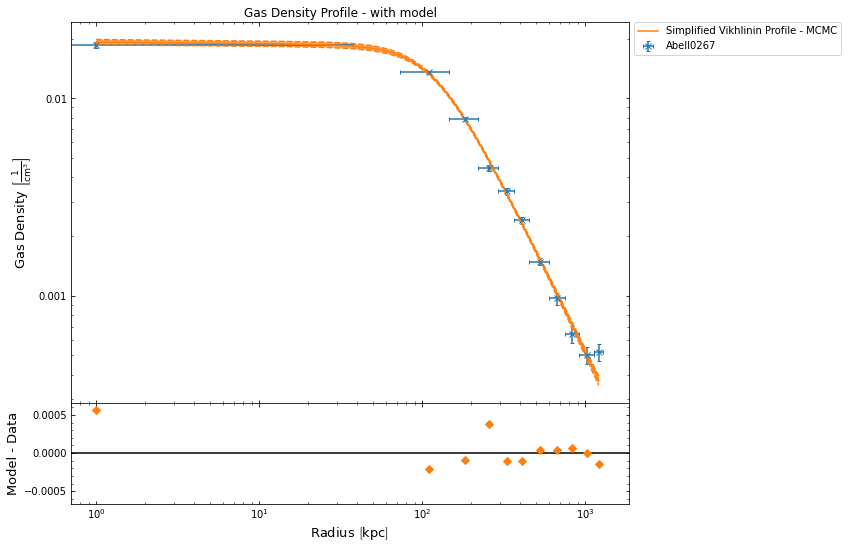

Measuring LoCuSS Gas Masses:  17%|███████▊                                     | 8/46 [04:41<24:10, 38.18s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1065.83069461 1269.0141264   767.95674223  957.0284741  1420.12589701
 1277.46178332]


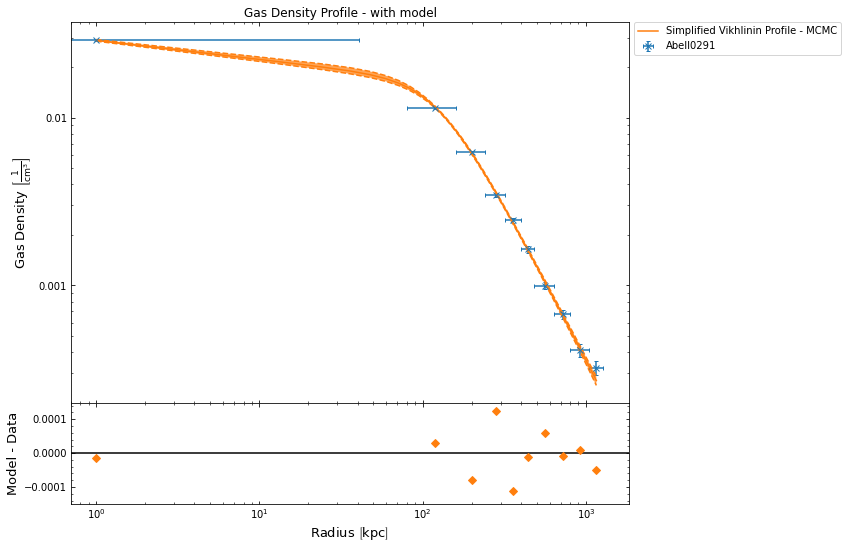

Measuring LoCuSS Gas Masses:  20%|████████▊                                    | 9/46 [05:23<24:18, 39.42s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1334.27325809 2345.49839019 3398.83248485 3137.77922308 2450.21785779
 3448.25488542]


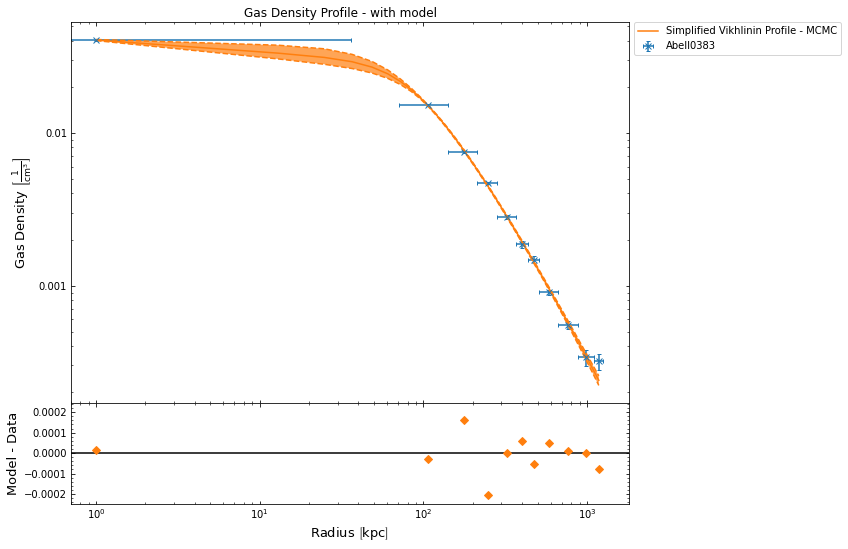

Measuring LoCuSS Gas Masses:  22%|█████████▌                                  | 10/46 [06:06<24:15, 40.44s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:960: RuntimeWarning: overflow encountered in true_divide
  frac_err = np.divide(fit_par_err, fit_par, where=fit_par != 0)


Initial state has a large condition number. Make sure that your walkers are linearly independent for the best performance


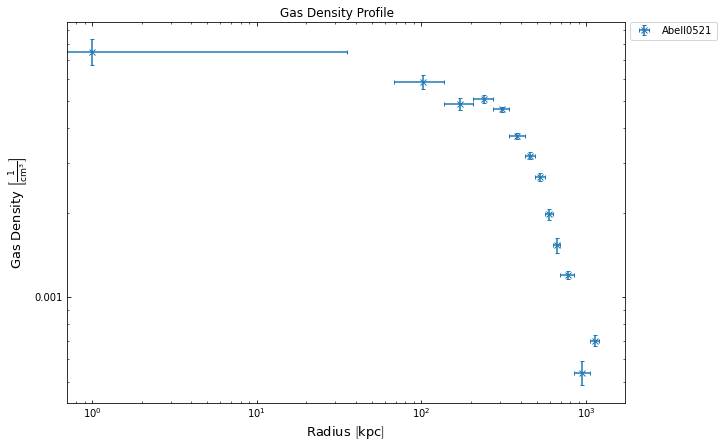

Measuring LoCuSS Gas Masses:  24%|██████████▌                                 | 11/46 [06:07<16:32, 28.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1670.50360804 1005.05801939  712.71443352  647.03662365 1514.18383034
 1268.32007213]


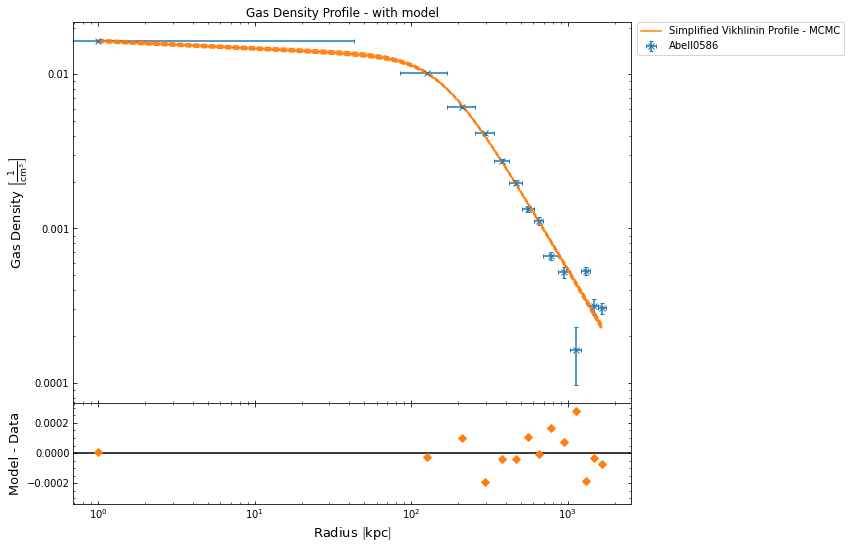

Measuring LoCuSS Gas Masses:  26%|███████████▍                                | 12/46 [06:46<18:00, 31.78s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 619.52192783 1385.16553655 2051.53807357 2085.6108649  1928.64365445
 2246.28090499]


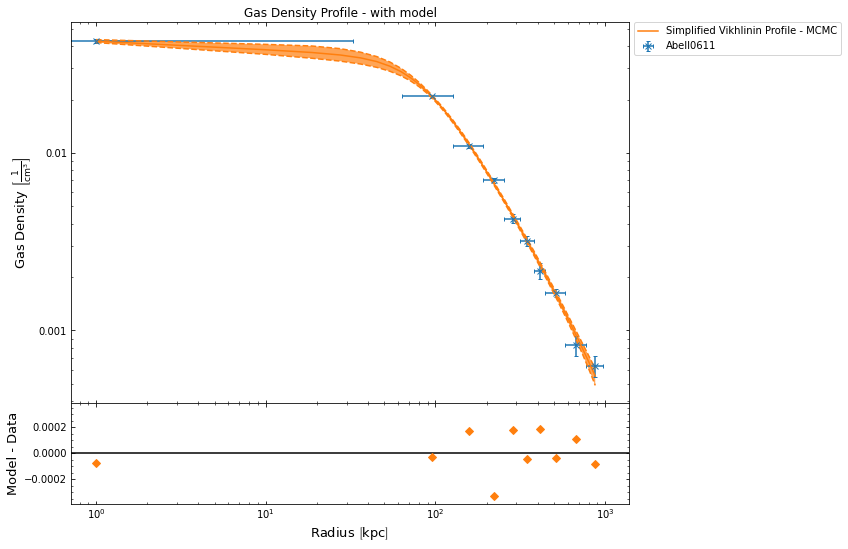

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:463: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  warn("The outer radius you supplied is greater than or equal to the outer radius covered by the data, so"
Measuring LoCuSS Gas Masses:  28%|████████████▍                               | 13/46 [07:27<18:58, 34.51s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2558.17797547 2060.78377852 1600.23787516 1556.69300357 2289.71641004
 2161.40850926]


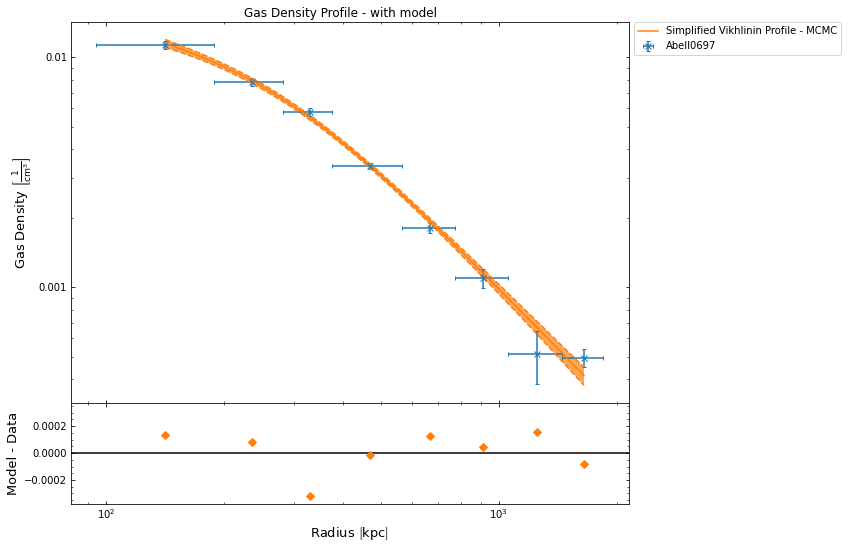

Measuring LoCuSS Gas Masses:  30%|█████████████▍                              | 14/46 [08:09<19:38, 36.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 284.50817717  697.7895232  1234.76317684  214.87652877  223.15324388
  395.18827695]


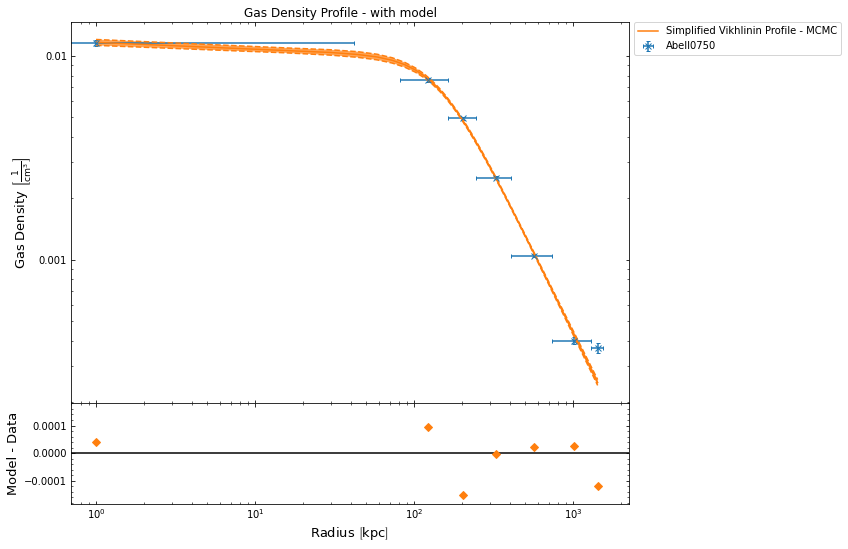

Measuring LoCuSS Gas Masses:  35%|███████████████▎                            | 16/46 [08:48<14:22, 28.75s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 95.07218329 338.42976246 750.09207961 138.65554838 133.39832966
 170.56635484]


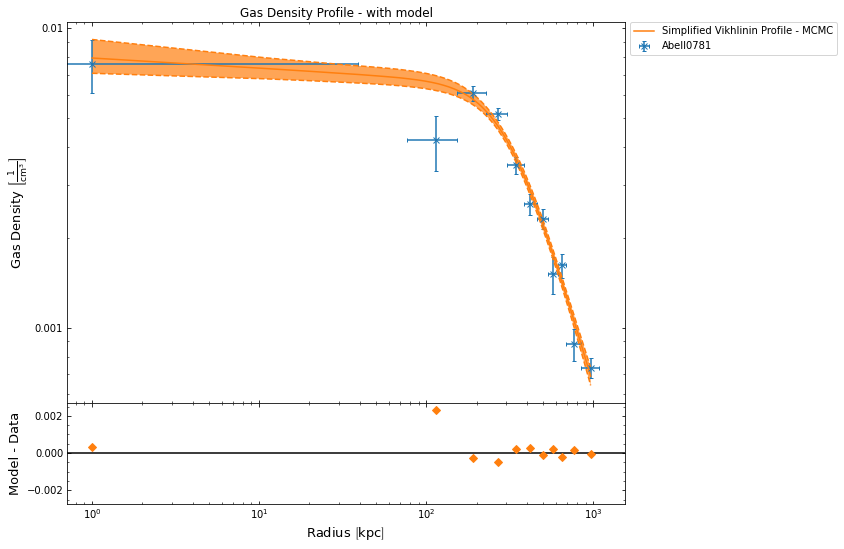

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:463: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  warn("The outer radius you supplied is greater than or equal to the outer radius covered by the data, so"
Measuring LoCuSS Gas Masses:  39%|█████████████████▏                          | 18/46 [09:26<11:35, 24.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 461.78427598  439.45318722 1309.44510779 1267.45029086  631.31249364
 1328.27729478]


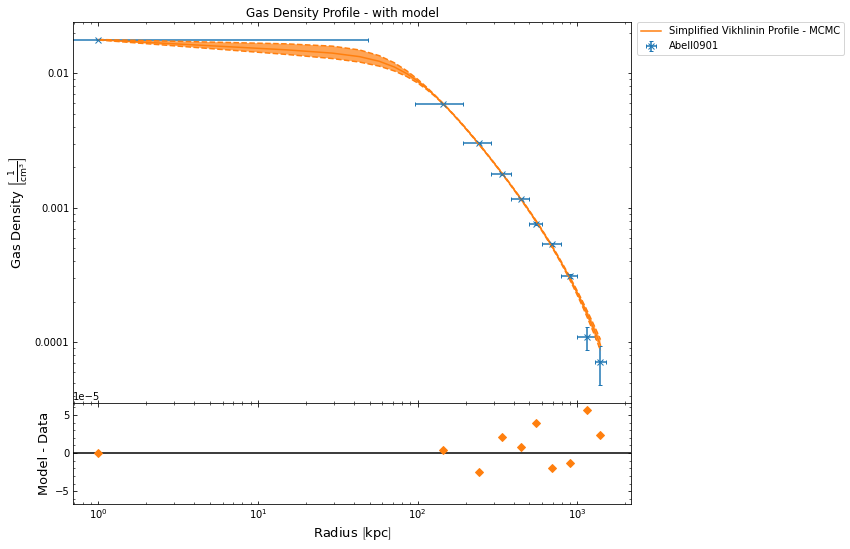

Measuring LoCuSS Gas Masses:  41%|██████████████████▏                         | 19/46 [10:09<13:01, 28.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 947.41906042 1071.77409769  462.506929    417.3867553   905.18345425
 1160.01581881]


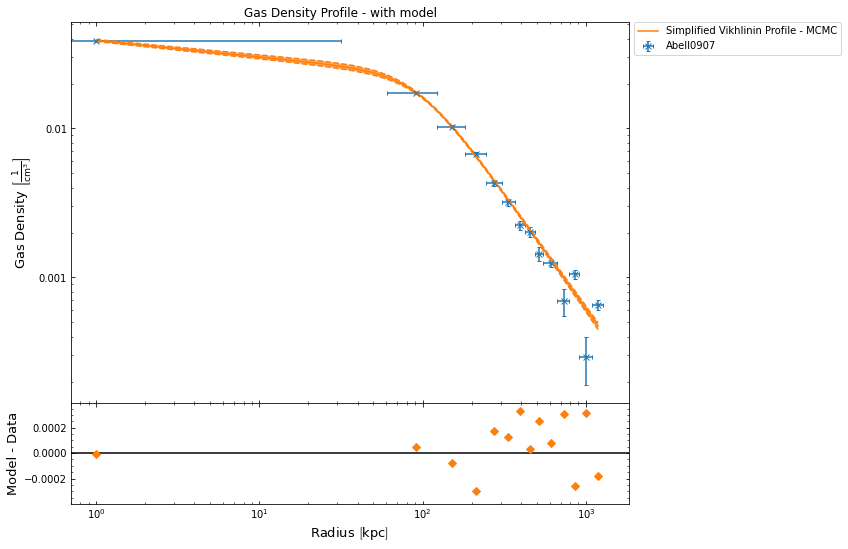

Measuring LoCuSS Gas Masses:  43%|███████████████████▏                        | 20/46 [10:50<13:48, 31.88s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2093.79384235 2224.92622605 1860.36717894 1574.98207934  652.92400688
 1892.30028174]


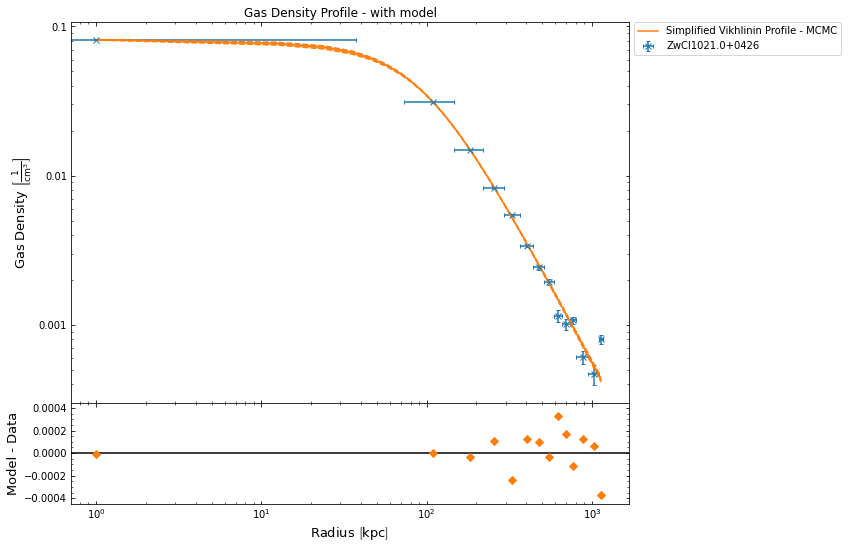

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:463: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  warn("The outer radius you supplied is greater than or equal to the outer radius covered by the data, so"
Measuring LoCuSS Gas Masses:  48%|█████████████████████                       | 22/46 [11:30<10:44, 26.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 256.55931393  654.25325154 1268.47527156  130.63270923  126.81246347
  200.89681631]


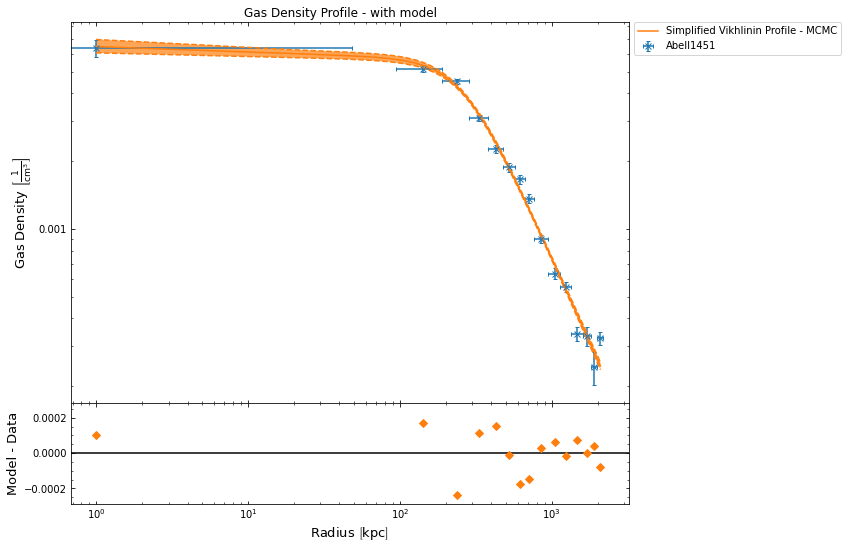

Measuring LoCuSS Gas Masses:  50%|██████████████████████                      | 23/46 [12:10<11:28, 29.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 235.05056223  471.30093549 2190.61074823  337.95238788  405.35765711
 1200.13529541]


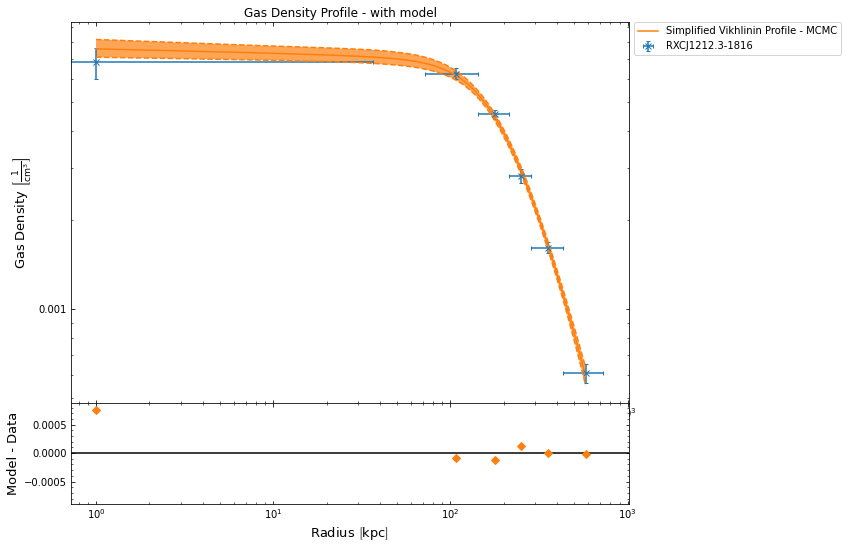

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:463: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  warn("The outer radius you supplied is greater than or equal to the outer radius covered by the data, so"
Measuring LoCuSS Gas Masses:  52%|██████████████████████▉                     | 24/46 [12:47<11:38, 31.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1998.99393859 2055.29854854 1758.67010707 1306.99970532 1931.04055493
 2023.69040708]


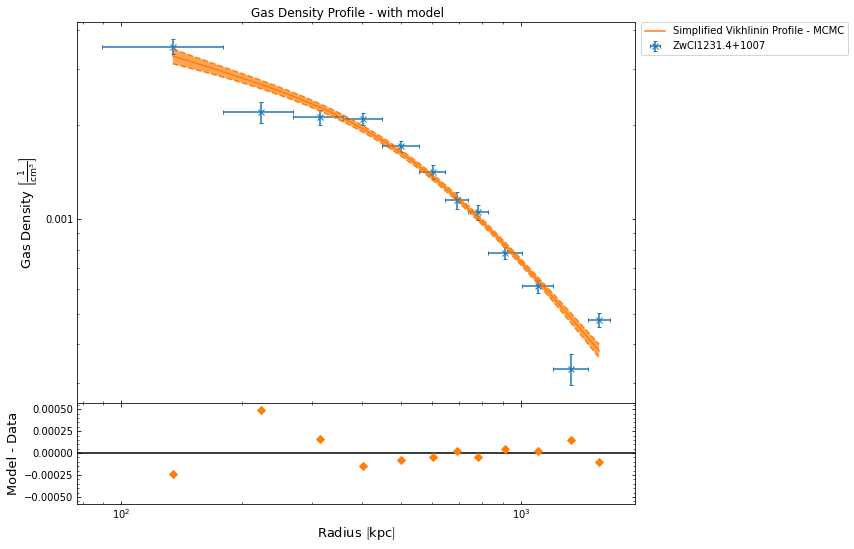

Measuring LoCuSS Gas Masses:  54%|███████████████████████▉                    | 25/46 [13:30<12:02, 34.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [283.98635756 445.72214332 825.68657477 733.56556357 401.17908904
 839.5874853 ]


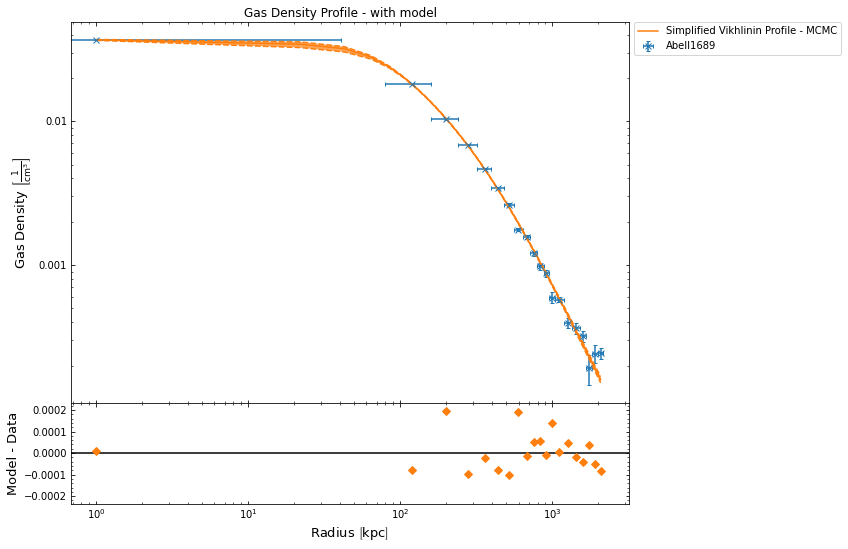

Measuring LoCuSS Gas Masses:  57%|████████████████████████▊                   | 26/46 [14:16<12:34, 37.72s/it]

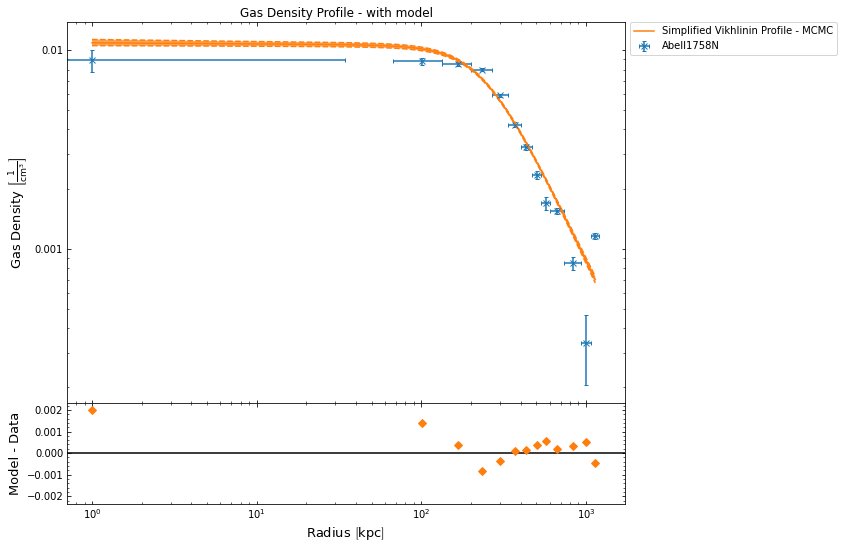

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:463: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  warn("The outer radius you supplied is greater than or equal to the outer radius covered by the data, so"
Measuring LoCuSS Gas Masses:  59%|█████████████████████████▊                  | 27/46 [14:55<12:00, 37.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1289.23458806  894.57734332  382.2328672   570.42186122 1285.70984406
  843.93777943]


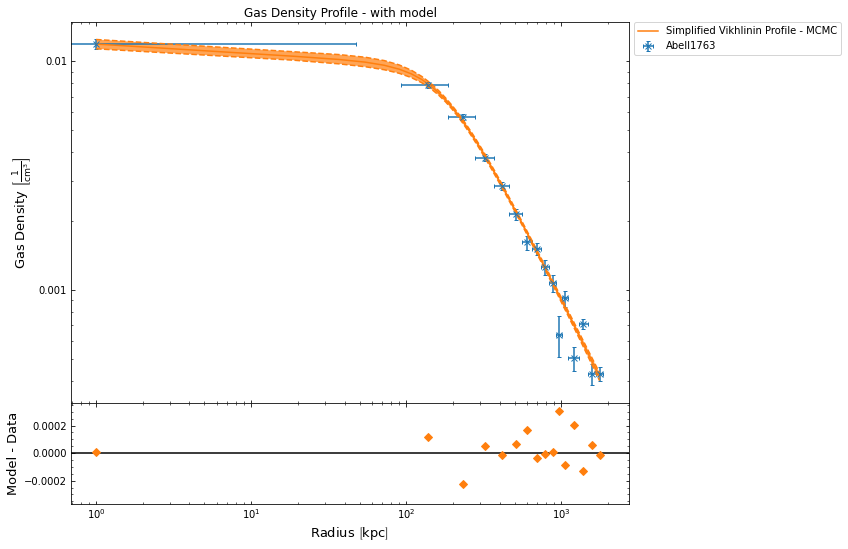

Measuring LoCuSS Gas Masses:  61%|██████████████████████████▊                 | 28/46 [15:35<11:32, 38.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1060.26678949 1110.1163537  2158.36168265 1912.35383187 1056.13038758
 2211.10877306]


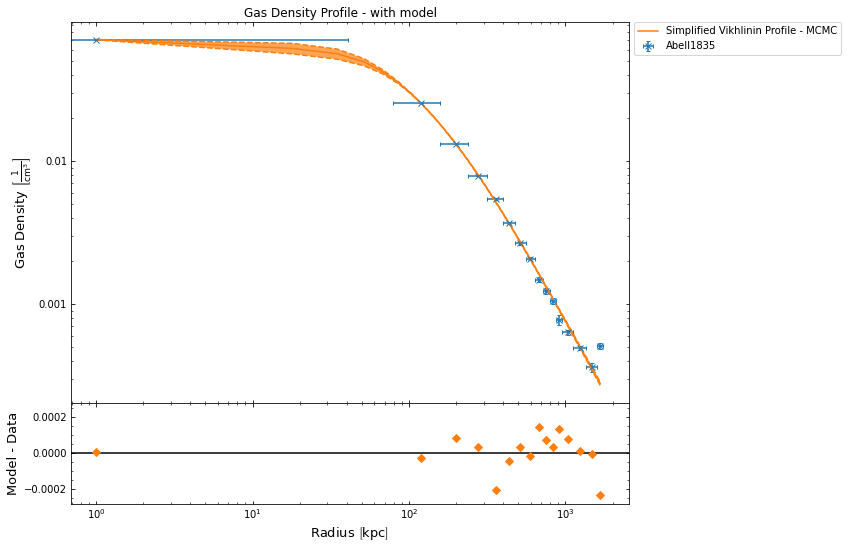

Measuring LoCuSS Gas Masses:  63%|███████████████████████████▋                | 29/46 [16:22<11:38, 41.08s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [3508.11407665 3212.87107639 1841.3372337  3170.15032691 3555.89264893
 2166.68083394]


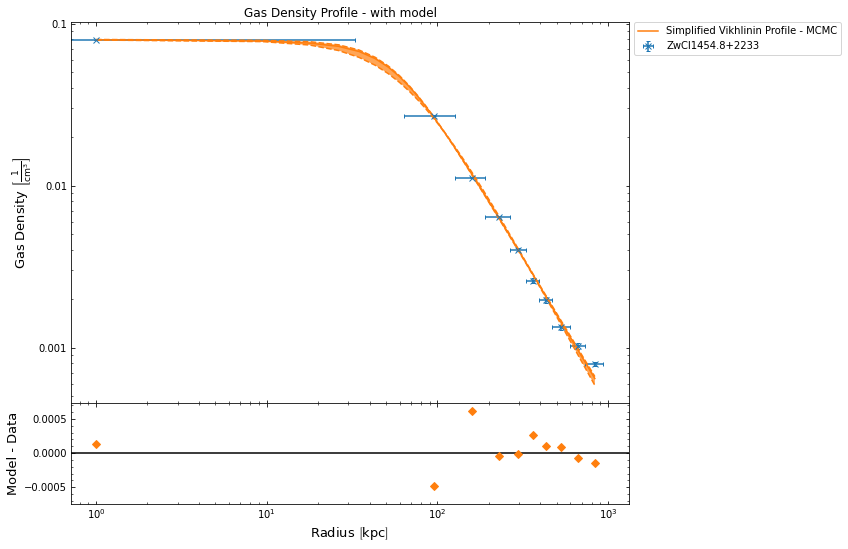

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:463: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  warn("The outer radius you supplied is greater than or equal to the outer radius covered by the data, so"
Measuring LoCuSS Gas Masses:  67%|█████████████████████████████▋              | 31/46 [17:00<07:46, 31.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1482.77311013 1670.59130609 1361.62469568 1688.59650572 1884.31638118
 1749.3436945 ]


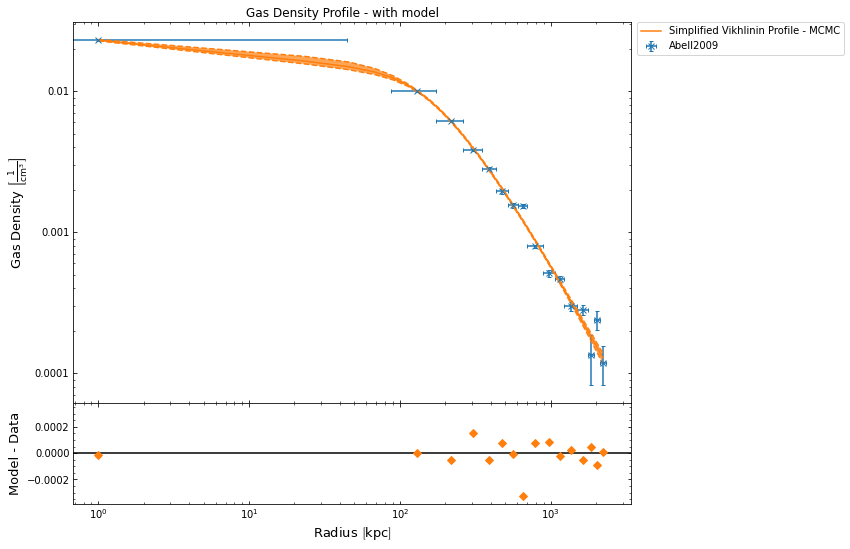

Measuring LoCuSS Gas Masses:  70%|██████████████████████████████▌             | 32/46 [17:46<08:05, 34.65s/it]

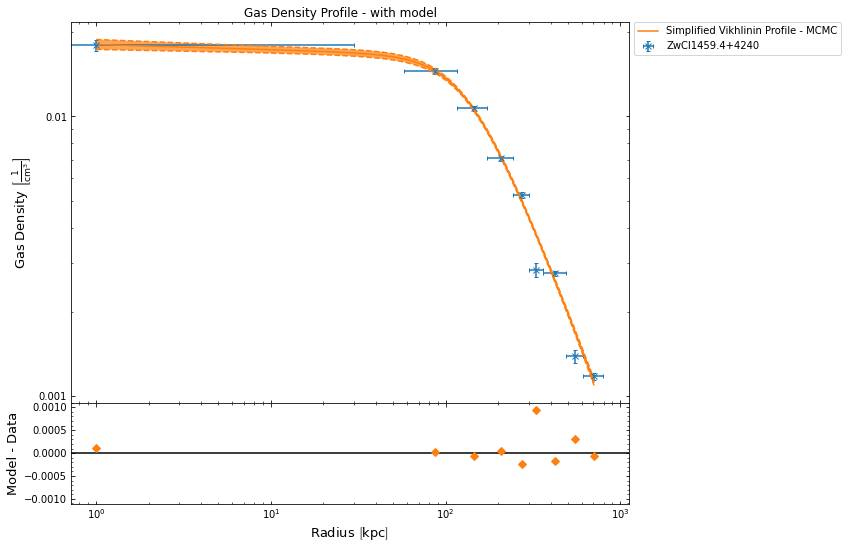

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:463: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  warn("The outer radius you supplied is greater than or equal to the outer radius covered by the data, so"
Measuring LoCuSS Gas Masses:  72%|███████████████████████████████▌            | 33/46 [18:25<07:46, 35.89s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2047.76943801 2169.20832253 2468.45006635 2266.00506153 2051.02494503
 2517.17079413]


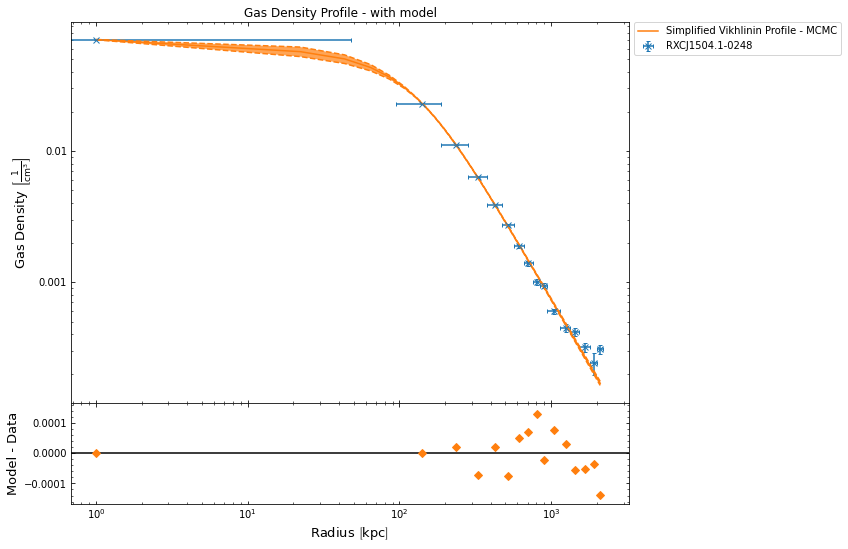

Measuring LoCuSS Gas Masses:  74%|████████████████████████████████▌           | 34/46 [19:10<07:40, 38.37s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [410.97635859 470.27484778 952.67721706 214.9011539  225.29306496
 249.28075408]


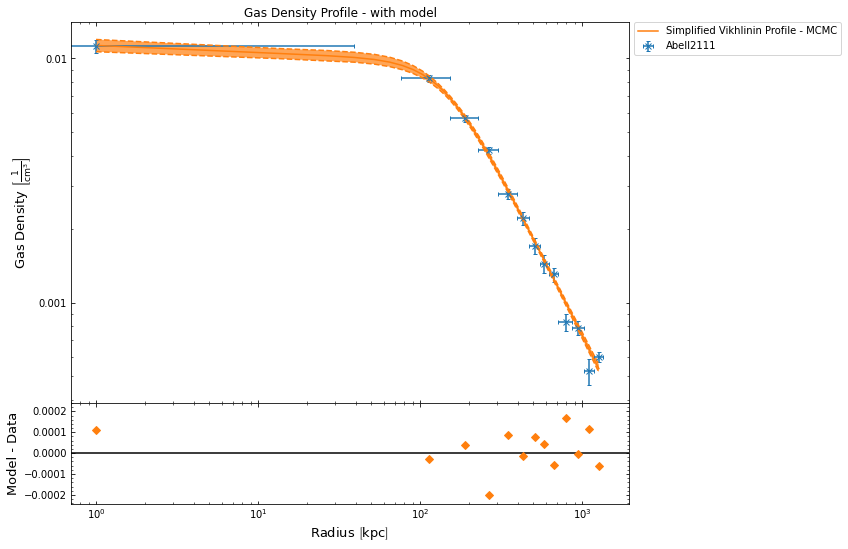

Measuring LoCuSS Gas Masses:  76%|█████████████████████████████████▍          | 35/46 [19:49<07:04, 38.58s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2410.62872254 2580.06242458 2525.18541268 1555.73335047 2410.84366689
 2569.07148038]


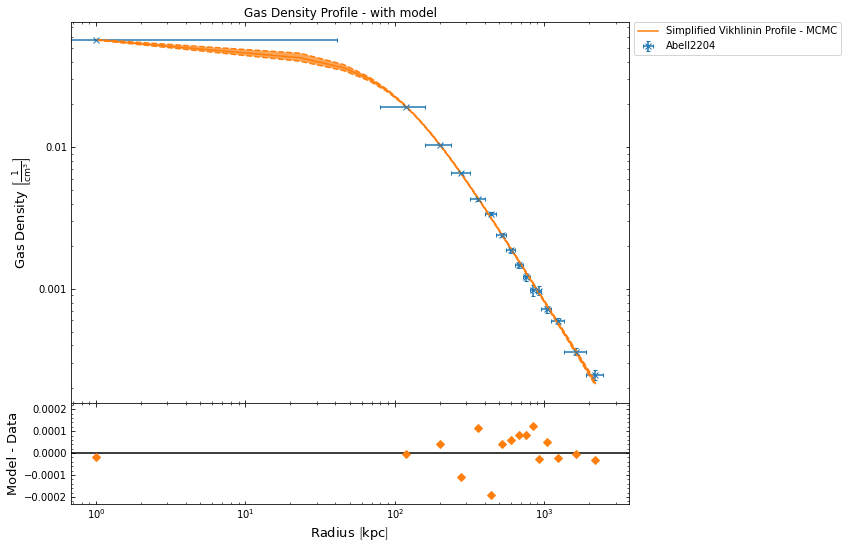

Measuring LoCuSS Gas Masses:  78%|██████████████████████████████████▍         | 36/46 [20:32<06:37, 39.71s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2631.1385093  2365.37055154 2254.85476815 2403.16481329 2662.56298263
 2609.51486903]


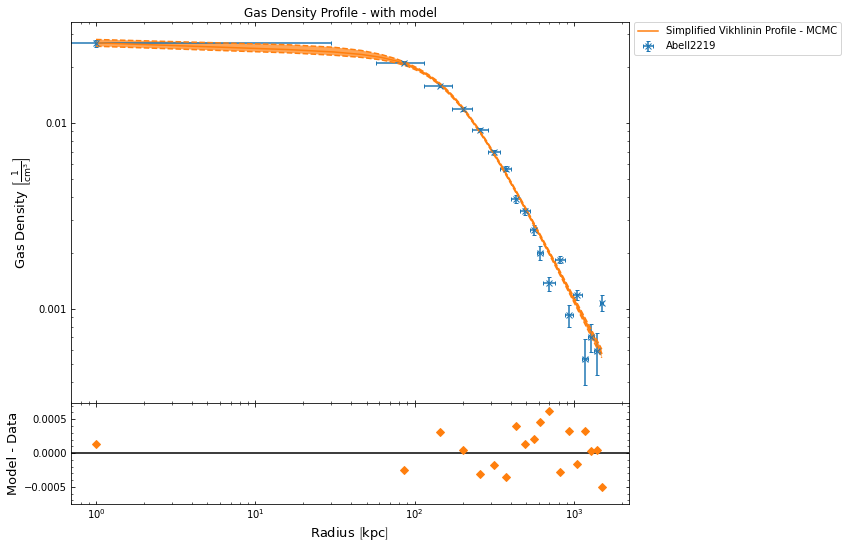

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:463: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  warn("The outer radius you supplied is greater than or equal to the outer radius covered by the data, so"
Measuring LoCuSS Gas Masses:  80%|███████████████████████████████████▍        | 37/46 [21:13<06:00, 40.01s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [976.08159614 622.51038626 212.87714739 246.11889219 623.89915129
 581.05518117]


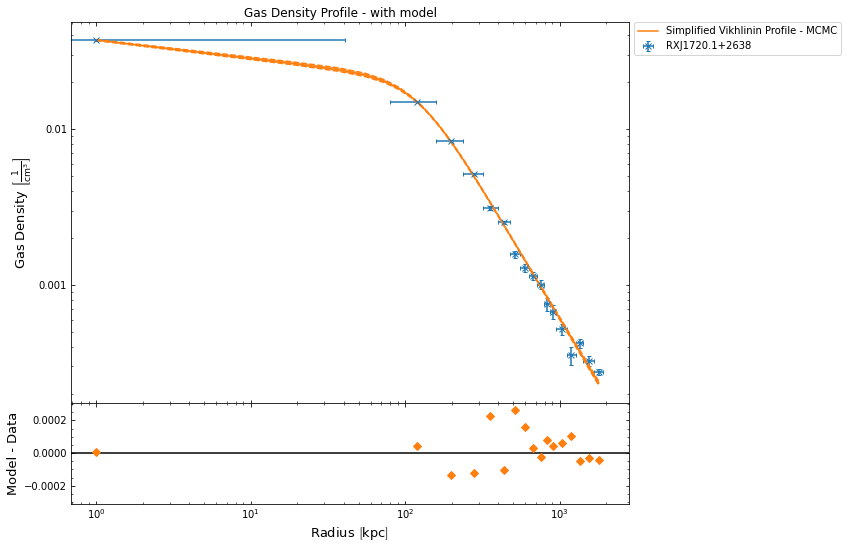

Measuring LoCuSS Gas Masses:  83%|████████████████████████████████████▎       | 38/46 [21:57<05:29, 41.24s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 331.4623921   378.76385098 1185.50615522  243.32458149  471.14068094
  648.30197675]


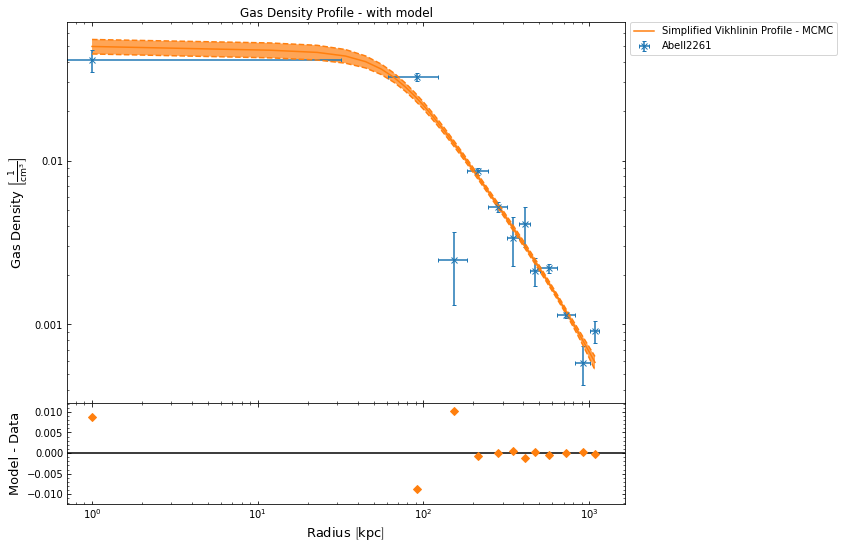

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:463: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  warn("The outer radius you supplied is greater than or equal to the outer radius covered by the data, so"
Measuring LoCuSS Gas Masses:  85%|█████████████████████████████████████▎      | 39/46 [22:39<04:49, 41.38s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1704.42038579 1443.35848934 1223.687192   1356.10604044 1585.36339923
 1453.34788469]


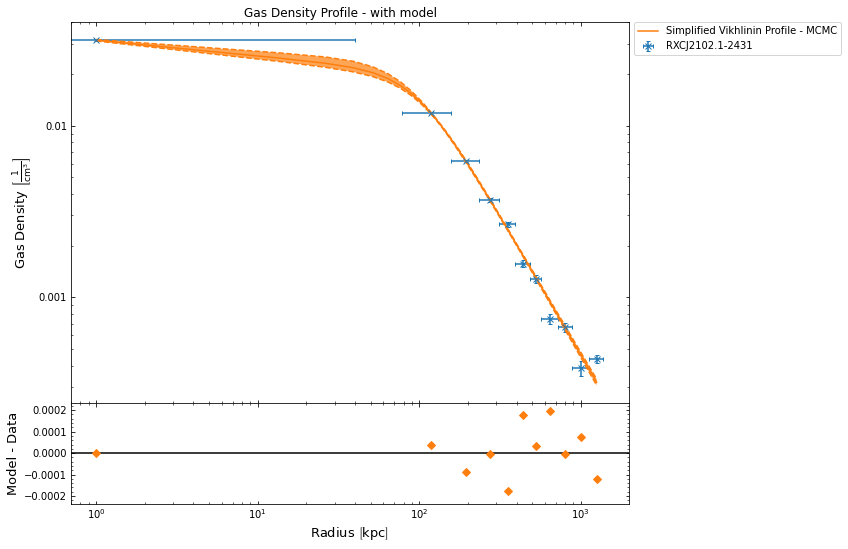

Measuring LoCuSS Gas Masses:  87%|██████████████████████████████████████▎     | 40/46 [23:21<04:09, 41.55s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1508.68331196 1260.99295118 1005.23466149 1169.26772821 1889.00646136
 1345.65265817]


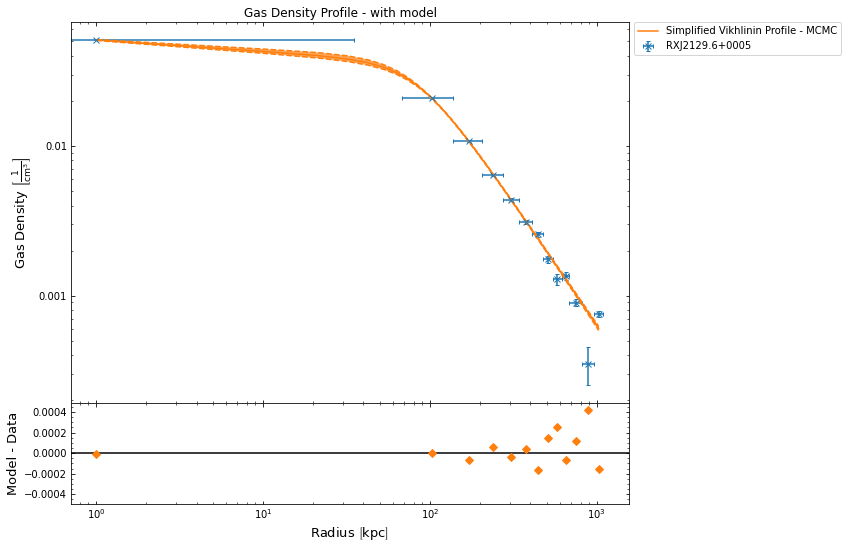

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:463: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  warn("The outer radius you supplied is greater than or equal to the outer radius covered by the data, so"
Measuring LoCuSS Gas Masses:  89%|███████████████████████████████████████▏    | 41/46 [24:03<03:29, 41.83s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 328.28111632  690.65404753 1011.76480326  864.86077348  686.1524815
 1051.59201336]


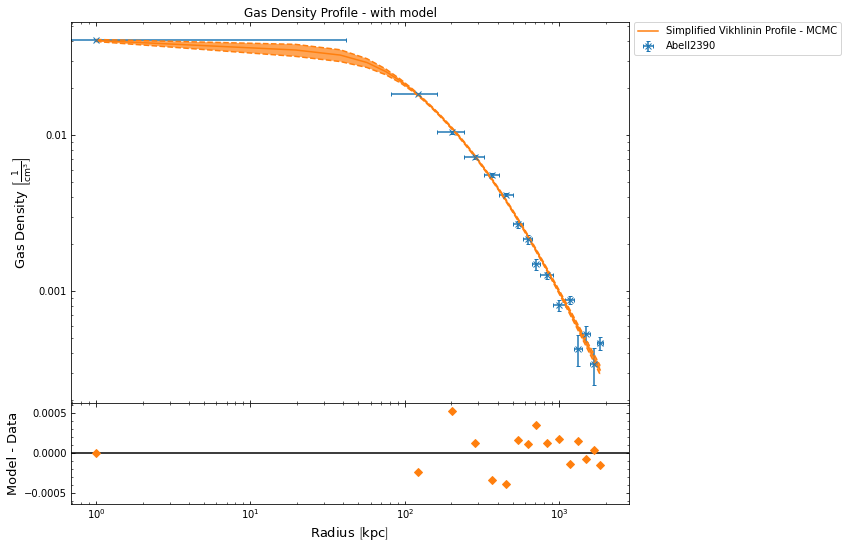

Measuring LoCuSS Gas Masses:  91%|████████████████████████████████████████▏   | 42/46 [24:50<02:54, 43.50s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1233.3987662  1981.59757791 2599.50428764 2326.74274506 2383.99065212
 2601.7728721 ]


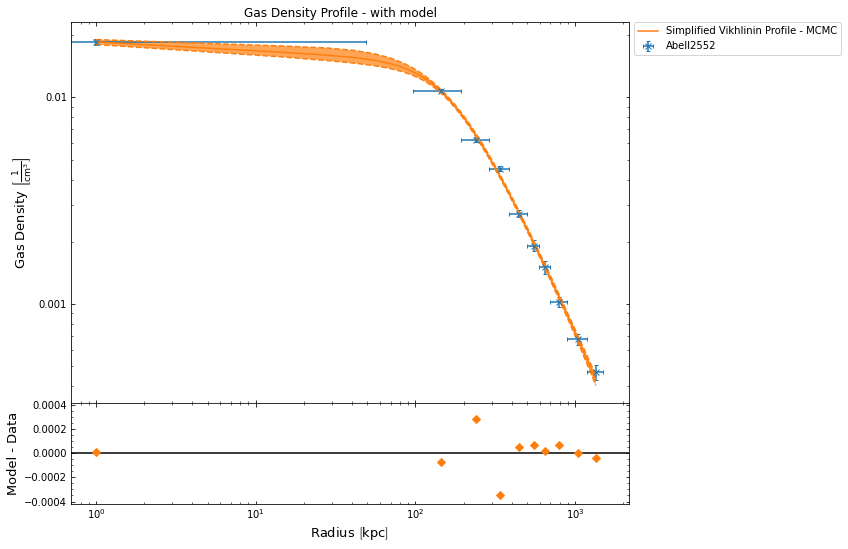

Measuring LoCuSS Gas Masses:  96%|██████████████████████████████████████████  | 44/46 [25:31<01:05, 32.77s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1650.73764641 2332.02870062 3125.93431643 1091.90266326 2450.91204216
 2954.9983116 ]


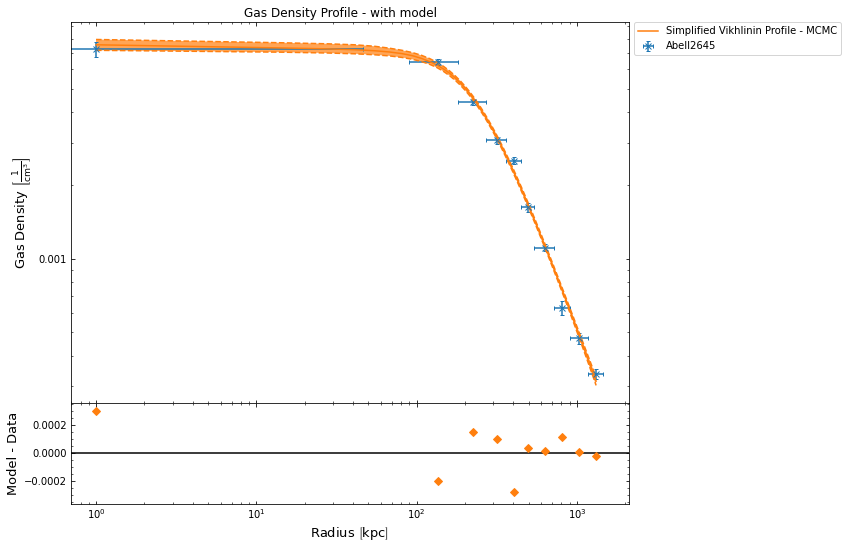

Measuring LoCuSS Gas Masses: 100%|████████████████████████████████████████████| 46/46 [26:09<00:00, 34.12s/it]


In [66]:
dpath = "non_paper_figures/density_profiles/svikh_12r500_annspec/"
if not os.path.exists(dpath):
    os.makedirs(dpath+"lovisari")
    os.makedirs(dpath+"locuss") 

lov_svikh_12_annspec_gm = []
with tqdm(desc="Measuring Lovisari Gas Masses", total=len(lov_annspec_12_dp)) as onwards:
    for dp in lov_annspec_12_dp:
        if dp is not None:
            rel_src = lovisari_srcs[dp.src_name]
            # Fit a simplified Vikhlinin density profile
            dp.fit("simple_vikhlinin_dens", progress_bar=False)
            dp.view(save_path=dpath+"lovisari/{}.pdf".format(rel_src.name))
            try:
                # Measure a gas mass within R500
                gm = dp.gas_mass("simple_vikhlinin_dens", rel_src.r500)[0]
                lov_svikh_12_annspec_gm.append(gm)
            except ModelNotAssociatedError:
                lov_svikh_12_annspec_gm.append([np.NaN, np.NaN, np.NaN])
        else:
            lov_svikh_12_annspec_gm.append([np.NaN, np.NaN, np.NaN])
    
        onwards.update(1)

loc_svikh_12_annspec_gm = []
with tqdm(desc="Measuring LoCuSS Gas Masses", total=len(loc_annspec_12_dp)) as onwards:
    for dp in loc_annspec_12_dp:
        if dp is not None:
            rel_src = locuss_srcs[dp.src_name]
            # Fit a simplified Vikhlinin density profile
            dp.fit("simple_vikhlinin_dens", progress_bar=False)
            dp.view(save_path=dpath+"locuss/{}.pdf".format(rel_src.name))
            try:
                # Measure a gas mass within R500
                gm = dp.gas_mass("simple_vikhlinin_dens", rel_src.r500)[0]
                loc_svikh_12_annspec_gm.append(gm)
            except ModelNotAssociatedError:
                loc_svikh_12_annspec_gm.append([np.NaN, np.NaN, np.NaN])
        else:
            loc_svikh_12_annspec_gm.append([np.NaN, np.NaN, np.NaN])
    
        onwards.update(1)

lov_svikh_12_annspec_gm = Quantity(lov_svikh_12_annspec_gm, 'Msun').astype(float)
loc_svikh_12_annspec_gm = Quantity(loc_svikh_12_annspec_gm, 'Msun').astype(float)

/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


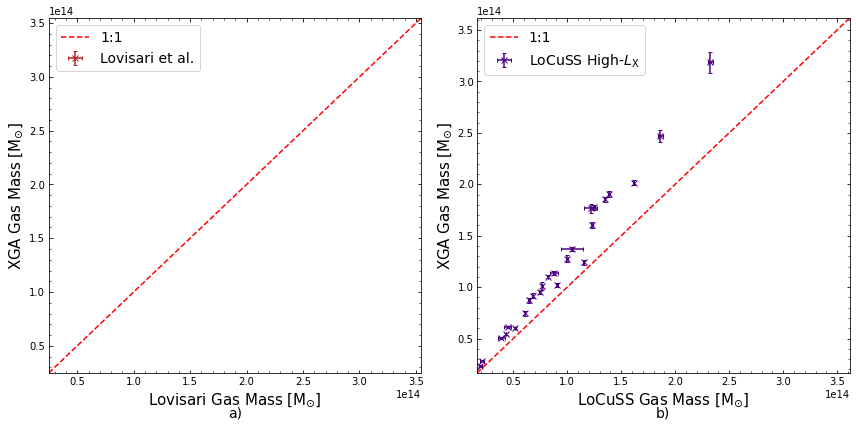

In [70]:
# Setting the y-position and font size of the a and b  labels that are added below the subplots
sublabel_ypos = -0.115
sublabel_fsize = 14

# Set up the matplotlib figure with 2 columns, meaning three subplots
fig, ax_arr = plt.subplots(ncols=2, figsize=(12, 6))

# Iterating through the array of axes objects, setting up the ticks
for ax in ax_arr:
    ax.minorticks_on()
    ax.tick_params(which='both', top=True, right=True, direction='in')

# Reading out the first axis in the array of axes
ax = ax_arr[0]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
lov_lims = find_lims(lov_lit_gms, lov_svikh_12_annspec_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(lov_lims, lov_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(lov_lit_gms[:, 0].value, lov_svikh_12_annspec_gm[:, 0].value, 
             xerr=lov_lit_gms[:, 1:].T.value, 
             yerr=lov_svikh_12_annspec_gm[:, 1:].T.value, fmt='x', 
             color=lov_colour, capsize=2, label="Lovisari et al.")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"Lovisari Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(lov_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(lov_lims)
ax.text(0.5, sublabel_ypos, s='a)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Reading out the second axis in the array of axes
ax = ax_arr[1]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
loc_lims = find_lims(loc_lit_gms, loc_svikh_12_annspec_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(loc_lims, loc_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(loc_lit_gms[:, 0].value, loc_svikh_12_annspec_gm[:, 0].value, 
             xerr=loc_lit_gms[:, 1].value, 
             yerr=loc_svikh_12_annspec_gm[:, 1:].T.value, fmt='x', 
             color=loc_colour, capsize=2, label=r"LoCuSS High-$L_{\rm{X}}$")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"LoCuSS Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(loc_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(loc_lims)
ax.text(0.5, sublabel_ypos, s='b)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Saving and plotting the resulting figure
plt.tight_layout()
plt.savefig("non_paper_figures/lov_loc_svikh_12r500_annspec_gm_comp.pdf")
plt.show()

### Simplified Vikhlinin Profiles - out to 1.05$R_{500}$

In [68]:
loc_annspec_105_dp = ann_spectra_apec_norm(locuss_srcs, locuss_srcs.r500*1.05, min_snr=30)
lov_annspec_105_dp = ann_spectra_apec_norm(lovisari_srcs, lovisari_srcs.r500*1.05, min_snr=30)

Generating products of type(s) spectrum:  20%|█████▉                       | 43/210 [17:16<1:07:05, 24.10s/it]


KeyboardInterrupt: 

In [ ]:
dpath = "non_paper_figures/density_profiles/svikh_105r500_annspec/"
if not os.path.exists(dpath):
    os.makedirs(dpath+"lovisari")
    os.makedirs(dpath+"locuss") 

lov_svikh_105_annspec_gm = []
with tqdm(desc="Measuring Lovisari Gas Masses", total=len(lov_annspec_105_dp)) as onwards:
    for dp in lov_annspec_105_dp:
        if dp is not None:
            rel_src = lovisari_srcs[dp.src_name]
            # Fit a simplified Vikhlinin density profile
            dp.fit("simple_vikhlinin_dens", progress_bar=False)
            dp.view(save_path=dpath+"lovisari/{}.pdf".format(rel_src.name))
            try:
                # Measure a gas mass within R500
                gm = dp.gas_mass("simple_vikhlinin_dens", rel_src.r500)[0]
                lov_svikh_105_annspec_gm.append(gm)
            except ModelNotAssociatedError:
                lov_svikh_105_annspec_gm.append([np.NaN, np.NaN, np.NaN])
        else:
            lov_svikh_105_annspec_gm.append([np.NaN, np.NaN, np.NaN])
    
        onwards.update(1)

loc_svikh_105_annspec_gm = []
with tqdm(desc="Measuring LoCuSS Gas Masses", total=len(loc_annspec_105_dp)) as onwards:
    for dp in loc_annspec_105_dp:
        if dp is not None:
            rel_src = locuss_srcs[dp.src_name]
            # Fit a simplified Vikhlinin density profile
            dp.fit("simple_vikhlinin_dens", progress_bar=False)
            dp.view(save_path=dpath+"locuss/{}.pdf".format(rel_src.name))
            try:
                # Measure a gas mass within R500
                gm = dp.gas_mass("simple_vikhlinin_dens", rel_src.r500)[0]
                loc_svikh_105_annspec_gm.append(gm)
            except ModelNotAssociatedError:
                loc_svikh_105_annspec_gm.append([np.NaN, np.NaN, np.NaN])
        else:
            loc_svikh_105_annspec_gm.append([np.NaN, np.NaN, np.NaN])
    
        onwards.update(1)

lov_svikh_105_annspec_gm = Quantity(lov_svikh_105_annspec_gm, 'Msun').astype(float)
loc_svikh_105_annspec_gm = Quantity(loc_svikh_105_annspec_gm, 'Msun').astype(float)

In [ ]:
# Setting the y-position and font size of the a and b  labels that are added below the subplots
sublabel_ypos = -0.115
sublabel_fsize = 14

# Set up the matplotlib figure with 2 columns, meaning three subplots
fig, ax_arr = plt.subplots(ncols=2, figsize=(12, 6))

# Iterating through the array of axes objects, setting up the ticks
for ax in ax_arr:
    ax.minorticks_on()
    ax.tick_params(which='both', top=True, right=True, direction='in')

# Reading out the first axis in the array of axes
ax = ax_arr[0]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
lov_lims = find_lims(lov_lit_gms, lov_svikh_105_annspec_gm).value
lov_lims[1] = 5e+14

# Plotting a 1:1 line to help with comparisons
plt.plot(lov_lims, lov_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(lov_lit_gms[:, 0].value, lov_svikh_105_annspec_gm[:, 0].value, 
             xerr=lov_lit_gms[:, 1:].T.value, 
             yerr=lov_svikh_105_annspec_gm[:, 1:].T.value, fmt='x', 
             color=lov_colour, capsize=2, label="Lovisari et al.")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"Lovisari Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(lov_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(lov_lims)
ax.text(0.5, sublabel_ypos, s='a)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Reading out the second axis in the array of axes
ax = ax_arr[1]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
loc_lims = find_lims(loc_lit_gms, loc_svikh_105_annspec_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(loc_lims, loc_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(loc_lit_gms[:, 0].value, loc_svikh_105_annspec_gm[:, 0].value, 
             xerr=loc_lit_gms[:, 1].value, 
             yerr=loc_svikh_105_annspec_gm[:, 1:].T.value, fmt='x', 
             color=loc_colour, capsize=2, label=r"LoCuSS High-$L_{\rm{X}}$")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"LoCuSS Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(loc_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(loc_lims)
ax.text(0.5, sublabel_ypos, s='b)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Saving and plotting the resulting figure
plt.tight_layout()
plt.show()